In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1418448, 828)
(1418448, 1)
validation
(214736, 828)
(214736, 1)
test
(156944, 828)
(156944, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/142 [..............................] - ETA: 2:47 - loss: 0.1339 - STD: 2.0079e-04 - MAE: 0.3522

  2/142 [..............................] - ETA: 1:18 - loss: 0.0836 - STD: 4.0555e-04 - MAE: 0.2453

  5/142 [>.............................] - ETA: 21s - loss: 0.0425 - STD: 3.5745e-04 - MAE: 0.1570 

  6/142 [>.............................] - ETA: 18s - loss: 0.0399 - STD: 3.1814e-04 - MAE: 0.1529

  7/142 [>.............................] - ETA: 17s - loss: 0.0383 - STD: 2.8467e-04 - MAE: 0.1509

  8/142 [>.............................] - ETA: 15s - loss: 0.0372 - STD: 2.5657e-04 - MAE: 0.1497

  9/142 [>.............................] - ETA: 14s - loss: 0.0364 - STD: 2.3307e-04 - MAE: 0.1489

 10/142 [=>............................] - ETA: 13s - loss: 0.0357 - STD: 2.1306e-04 - MAE: 0.1482

 11/142 [=>............................] - ETA: 13s - loss: 0.0351 - STD: 1.9599e-04 - MAE: 0.1472

 12/142 [=>............................] - ETA: 12s - loss: 0.0344 - STD: 1.8124e-04 - MAE: 0.1462

 13/142 [=>............................] - ETA: 12s - loss: 0.0338 - STD: 1.6858e-04 - MAE: 0.1449

 14/142 [=>............................] - ETA: 11s - loss: 0.0331 - STD: 1.5780e-04 - MAE: 0.1432

 15/142 [==>...........................] - ETA: 11s - loss: 0.0323 - STD: 1.4877e-04 - MAE: 0.1412

 16/142 [==>...........................] - ETA: 10s - loss: 0.0315 - STD: 1.4126e-04 - MAE: 0.1389

 17/142 [==>...........................] - ETA: 10s - loss: 0.0306 - STD: 1.3508e-04 - MAE: 0.1362

 18/142 [==>...........................] - ETA: 10s - loss: 0.0297 - STD: 1.3006e-04 - MAE: 0.1334

 19/142 [===>..........................] - ETA: 10s - loss: 0.0287 - STD: 1.2598e-04 - MAE: 0.1306

 20/142 [===>..........................] - ETA: 9s - loss: 0.0279 - STD: 1.2256e-04 - MAE: 0.1280 

 21/142 [===>..........................] - ETA: 9s - loss: 0.0270 - STD: 1.1961e-04 - MAE: 0.1256

 22/142 [===>..........................] - ETA: 9s - loss: 0.0262 - STD: 1.1707e-04 - MAE: 0.1236

 23/142 [===>..........................] - ETA: 9s - loss: 0.0256 - STD: 1.1470e-04 - MAE: 0.1220

 24/142 [====>.........................] - ETA: 9s - loss: 0.0250 - STD: 1.1241e-04 - MAE: 0.1209

 25/142 [====>.........................] - ETA: 8s - loss: 0.0245 - STD: 1.1013e-04 - MAE: 0.1200

 26/142 [====>.........................] - ETA: 8s - loss: 0.0241 - STD: 1.0788e-04 - MAE: 0.1192

 27/142 [====>.........................] - ETA: 8s - loss: 0.0237 - STD: 1.0560e-04 - MAE: 0.1184

 28/142 [====>.........................] - ETA: 8s - loss: 0.0233 - STD: 1.0328e-04 - MAE: 0.1176

 29/142 [=====>........................] - ETA: 8s - loss: 0.0229 - STD: 1.0099e-04 - MAE: 0.1167

 30/142 [=====>........................] - ETA: 8s - loss: 0.0225 - STD: 9.8777e-05 - MAE: 0.1157

 31/142 [=====>........................] - ETA: 8s - loss: 0.0221 - STD: 9.6563e-05 - MAE: 0.1146

 32/142 [=====>........................] - ETA: 8s - loss: 0.0217 - STD: 9.4440e-05 - MAE: 0.1135

 33/142 [=====>........................] - ETA: 7s - loss: 0.0214 - STD: 9.2435e-05 - MAE: 0.1124

 34/142 [======>.......................] - ETA: 7s - loss: 0.0210 - STD: 9.0537e-05 - MAE: 0.1114

 35/142 [======>.......................] - ETA: 7s - loss: 0.0208 - STD: 8.8743e-05 - MAE: 0.1104

 36/142 [======>.......................] - ETA: 7s - loss: 0.0205 - STD: 8.7102e-05 - MAE: 0.1095

 37/142 [======>.......................] - ETA: 7s - loss: 0.0202 - STD: 8.5549e-05 - MAE: 0.1086

 38/142 [=======>......................] - ETA: 7s - loss: 0.0200 - STD: 8.4116e-05 - MAE: 0.1078

 39/142 [=======>......................] - ETA: 7s - loss: 0.0198 - STD: 8.2793e-05 - MAE: 0.1070

 40/142 [=======>......................] - ETA: 7s - loss: 0.0195 - STD: 8.1523e-05 - MAE: 0.1063

 41/142 [=======>......................] - ETA: 7s - loss: 0.0193 - STD: 8.0333e-05 - MAE: 0.1056

 42/142 [=======>......................] - ETA: 7s - loss: 0.0191 - STD: 7.9225e-05 - MAE: 0.1049

 43/142 [========>.....................] - ETA: 6s - loss: 0.0189 - STD: 7.8215e-05 - MAE: 0.1042

 44/142 [========>.....................] - ETA: 6s - loss: 0.0187 - STD: 7.7277e-05 - MAE: 0.1036

 45/142 [========>.....................] - ETA: 6s - loss: 0.0185 - STD: 7.6425e-05 - MAE: 0.1031

 46/142 [========>.....................] - ETA: 6s - loss: 0.0183 - STD: 7.5625e-05 - MAE: 0.1025

 47/142 [========>.....................] - ETA: 6s - loss: 0.0182 - STD: 7.4910e-05 - MAE: 0.1020

 48/142 [=========>....................] - ETA: 6s - loss: 0.0180 - STD: 7.4241e-05 - MAE: 0.1016

 49/142 [=========>....................] - ETA: 6s - loss: 0.0178 - STD: 7.3614e-05 - MAE: 0.1012

 50/142 [=========>....................] - ETA: 6s - loss: 0.0177 - STD: 7.3032e-05 - MAE: 0.1008

 51/142 [=========>....................] - ETA: 6s - loss: 0.0175 - STD: 7.2532e-05 - MAE: 0.1004

 52/142 [=========>....................] - ETA: 6s - loss: 0.0174 - STD: 7.2066e-05 - MAE: 0.1001

 53/142 [==========>...................] - ETA: 6s - loss: 0.0173 - STD: 7.1618e-05 - MAE: 0.0997

 54/142 [==========>...................] - ETA: 5s - loss: 0.0171 - STD: 7.1241e-05 - MAE: 0.0994

 55/142 [==========>...................] - ETA: 5s - loss: 0.0170 - STD: 7.0883e-05 - MAE: 0.0991

 56/142 [==========>...................] - ETA: 5s - loss: 0.0169 - STD: 7.0592e-05 - MAE: 0.0987

 57/142 [===========>..................] - ETA: 5s - loss: 0.0168 - STD: 7.0298e-05 - MAE: 0.0984

 58/142 [===========>..................] - ETA: 5s - loss: 0.0166 - STD: 7.0044e-05 - MAE: 0.0980

 59/142 [===========>..................] - ETA: 5s - loss: 0.0165 - STD: 6.9842e-05 - MAE: 0.0977

 60/142 [===========>..................] - ETA: 5s - loss: 0.0164 - STD: 6.9665e-05 - MAE: 0.0974

 61/142 [===========>..................] - ETA: 5s - loss: 0.0163 - STD: 6.9534e-05 - MAE: 0.0970

 62/142 [============>.................] - ETA: 5s - loss: 0.0162 - STD: 6.9434e-05 - MAE: 0.0967

 63/142 [============>.................] - ETA: 5s - loss: 0.0161 - STD: 6.9361e-05 - MAE: 0.0964

 64/142 [============>.................] - ETA: 5s - loss: 0.0160 - STD: 6.9314e-05 - MAE: 0.0962

 65/142 [============>.................] - ETA: 5s - loss: 0.0160 - STD: 6.9290e-05 - MAE: 0.0959

 66/142 [============>.................] - ETA: 5s - loss: 0.0159 - STD: 6.9281e-05 - MAE: 0.0956

 67/142 [=============>................] - ETA: 5s - loss: 0.0158 - STD: 6.9300e-05 - MAE: 0.0953

 68/142 [=============>................] - ETA: 4s - loss: 0.0157 - STD: 6.9367e-05 - MAE: 0.0951

 69/142 [=============>................] - ETA: 4s - loss: 0.0156 - STD: 6.9473e-05 - MAE: 0.0949

 70/142 [=============>................] - ETA: 4s - loss: 0.0155 - STD: 6.9605e-05 - MAE: 0.0946

 71/142 [==============>...............] - ETA: 4s - loss: 0.0155 - STD: 6.9751e-05 - MAE: 0.0944

 72/142 [==============>...............] - ETA: 4s - loss: 0.0154 - STD: 6.9909e-05 - MAE: 0.0942

 73/142 [==============>...............] - ETA: 4s - loss: 0.0153 - STD: 7.0096e-05 - MAE: 0.0940

 74/142 [==============>...............] - ETA: 4s - loss: 0.0153 - STD: 7.0304e-05 - MAE: 0.0938

 75/142 [==============>...............] - ETA: 4s - loss: 0.0152 - STD: 7.0540e-05 - MAE: 0.0936

 76/142 [===============>..............] - ETA: 4s - loss: 0.0151 - STD: 7.0809e-05 - MAE: 0.0935

 77/142 [===============>..............] - ETA: 4s - loss: 0.0150 - STD: 7.1099e-05 - MAE: 0.0933

 78/142 [===============>..............] - ETA: 4s - loss: 0.0150 - STD: 7.1407e-05 - MAE: 0.0931

 79/142 [===============>..............] - ETA: 4s - loss: 0.0149 - STD: 7.1728e-05 - MAE: 0.0929

 80/142 [===============>..............] - ETA: 4s - loss: 0.0149 - STD: 7.2079e-05 - MAE: 0.0927

 81/142 [================>.............] - ETA: 4s - loss: 0.0148 - STD: 7.2450e-05 - MAE: 0.0926

 82/142 [================>.............] - ETA: 3s - loss: 0.0148 - STD: 7.2843e-05 - MAE: 0.0924

 83/142 [================>.............] - ETA: 3s - loss: 0.0147 - STD: 7.3247e-05 - MAE: 0.0922

 84/142 [================>.............] - ETA: 3s - loss: 0.0146 - STD: 7.3676e-05 - MAE: 0.0921

 85/142 [================>.............] - ETA: 3s - loss: 0.0146 - STD: 7.4125e-05 - MAE: 0.0919

 86/142 [=================>............] - ETA: 3s - loss: 0.0145 - STD: 7.4609e-05 - MAE: 0.0917

 87/142 [=================>............] - ETA: 3s - loss: 0.0145 - STD: 7.5111e-05 - MAE: 0.0916

 88/142 [=================>............] - ETA: 3s - loss: 0.0144 - STD: 7.5615e-05 - MAE: 0.0914

 89/142 [=================>............] - ETA: 3s - loss: 0.0144 - STD: 7.6162e-05 - MAE: 0.0913

 90/142 [==================>...........] - ETA: 3s - loss: 0.0143 - STD: 7.6720e-05 - MAE: 0.0912

 91/142 [==================>...........] - ETA: 3s - loss: 0.0143 - STD: 7.7302e-05 - MAE: 0.0910

 92/142 [==================>...........] - ETA: 3s - loss: 0.0143 - STD: 7.7902e-05 - MAE: 0.0909

 93/142 [==================>...........] - ETA: 3s - loss: 0.0142 - STD: 7.8525e-05 - MAE: 0.0908

 94/142 [==================>...........] - ETA: 3s - loss: 0.0142 - STD: 7.9173e-05 - MAE: 0.0906

 95/142 [===================>..........] - ETA: 3s - loss: 0.0141 - STD: 7.9840e-05 - MAE: 0.0905

 96/142 [===================>..........] - ETA: 3s - loss: 0.0141 - STD: 8.0539e-05 - MAE: 0.0904

 97/142 [===================>..........] - ETA: 2s - loss: 0.0140 - STD: 8.1247e-05 - MAE: 0.0903

 98/142 [===================>..........] - ETA: 2s - loss: 0.0140 - STD: 8.1970e-05 - MAE: 0.0902

 99/142 [===================>..........] - ETA: 2s - loss: 0.0140 - STD: 8.2734e-05 - MAE: 0.0900

100/142 [====================>.........] - ETA: 2s - loss: 0.0139 - STD: 8.3523e-05 - MAE: 0.0899

101/142 [====================>.........] - ETA: 2s - loss: 0.0139 - STD: 8.4316e-05 - MAE: 0.0898

102/142 [====================>.........] - ETA: 2s - loss: 0.0138 - STD: 8.5137e-05 - MAE: 0.0897

103/142 [====================>.........] - ETA: 2s - loss: 0.0138 - STD: 8.5999e-05 - MAE: 0.0896

104/142 [====================>.........] - ETA: 2s - loss: 0.0138 - STD: 8.6860e-05 - MAE: 0.0895

105/142 [=====================>........] - ETA: 2s - loss: 0.0137 - STD: 8.7748e-05 - MAE: 0.0894

106/142 [=====================>........] - ETA: 2s - loss: 0.0137 - STD: 8.8685e-05 - MAE: 0.0893

107/142 [=====================>........] - ETA: 2s - loss: 0.0137 - STD: 8.9628e-05 - MAE: 0.0892

108/142 [=====================>........] - ETA: 2s - loss: 0.0136 - STD: 9.0600e-05 - MAE: 0.0891

109/142 [======================>.......] - ETA: 2s - loss: 0.0136 - STD: 9.1621e-05 - MAE: 0.0890

110/142 [======================>.......] - ETA: 2s - loss: 0.0136 - STD: 9.2642e-05 - MAE: 0.0889

111/142 [======================>.......] - ETA: 2s - loss: 0.0135 - STD: 9.3712e-05 - MAE: 0.0888

112/142 [======================>.......] - ETA: 1s - loss: 0.0135 - STD: 9.4810e-05 - MAE: 0.0887

113/142 [======================>.......] - ETA: 1s - loss: 0.0135 - STD: 9.5924e-05 - MAE: 0.0886

114/142 [=======================>......] - ETA: 1s - loss: 0.0134 - STD: 9.7055e-05 - MAE: 0.0885

115/142 [=======================>......] - ETA: 1s - loss: 0.0134 - STD: 9.8249e-05 - MAE: 0.0884

116/142 [=======================>......] - ETA: 1s - loss: 0.0134 - STD: 9.9486e-05 - MAE: 0.0883

117/142 [=======================>......] - ETA: 1s - loss: 0.0134 - STD: 1.0073e-04 - MAE: 0.0882

118/142 [=======================>......] - ETA: 1s - loss: 0.0133 - STD: 1.0204e-04 - MAE: 0.0882

119/142 [========================>.....] - ETA: 1s - loss: 0.0133 - STD: 1.0335e-04 - MAE: 0.0881

120/142 [========================>.....] - ETA: 1s - loss: 0.0133 - STD: 1.0471e-04 - MAE: 0.0880

121/142 [========================>.....] - ETA: 1s - loss: 0.0132 - STD: 1.0612e-04 - MAE: 0.0879

122/142 [========================>.....] - ETA: 1s - loss: 0.0132 - STD: 1.0755e-04 - MAE: 0.0878

123/142 [========================>.....] - ETA: 1s - loss: 0.0132 - STD: 1.0901e-04 - MAE: 0.0878

124/142 [=========================>....] - ETA: 1s - loss: 0.0132 - STD: 1.1053e-04 - MAE: 0.0877

125/142 [=========================>....] - ETA: 1s - loss: 0.0131 - STD: 1.1212e-04 - MAE: 0.0876

126/142 [=========================>....] - ETA: 1s - loss: 0.0131 - STD: 1.1371e-04 - MAE: 0.0876

127/142 [=========================>....] - ETA: 0s - loss: 0.0131 - STD: 1.1535e-04 - MAE: 0.0875

128/142 [==========================>...] - ETA: 0s - loss: 0.0131 - STD: 1.1704e-04 - MAE: 0.0874

129/142 [==========================>...] - ETA: 0s - loss: 0.0130 - STD: 1.1875e-04 - MAE: 0.0874

130/142 [==========================>...] - ETA: 0s - loss: 0.0130 - STD: 1.2052e-04 - MAE: 0.0873

131/142 [==========================>...] - ETA: 0s - loss: 0.0130 - STD: 1.2234e-04 - MAE: 0.0872

132/142 [==========================>...] - ETA: 0s - loss: 0.0130 - STD: 1.2423e-04 - MAE: 0.0872

133/142 [===========================>..] - ETA: 0s - loss: 0.0130 - STD: 1.2618e-04 - MAE: 0.0871

134/142 [===========================>..] - ETA: 0s - loss: 0.0129 - STD: 1.2818e-04 - MAE: 0.0870

135/142 [===========================>..] - ETA: 0s - loss: 0.0129 - STD: 1.3022e-04 - MAE: 0.0870

136/142 [===========================>..] - ETA: 0s - loss: 0.0129 - STD: 1.3234e-04 - MAE: 0.0869

137/142 [===========================>..] - ETA: 0s - loss: 0.0129 - STD: 1.3454e-04 - MAE: 0.0868

138/142 [============================>.] - ETA: 0s - loss: 0.0129 - STD: 1.3676e-04 - MAE: 0.0868

139/142 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 1.3908e-04 - MAE: 0.0867

140/142 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 1.4145e-04 - MAE: 0.0867

141/142 [============================>.] - ETA: 0s - loss: 0.0128 - STD: 1.4390e-04 - MAE: 0.0866

142/142 [==============================] - ETA: 0s - loss: 0.0128 - STD: 1.4644e-04 - MAE: 0.0865

142/142 [==============================] - 11s 70ms/step - loss: 0.0128 - STD: 1.4644e-04 - MAE: 0.0865 - val_loss: 0.0109 - val_STD: 3.5895e-04 - val_MAE: 0.0805


Epoch 2/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0103 - STD: 5.1954e-04 - MAE: 0.0799

  2/142 [..............................] - ETA: 8s - loss: 0.0101 - STD: 5.2672e-04 - MAE: 0.0787 

  3/142 [..............................] - ETA: 8s - loss: 0.0100 - STD: 5.3479e-04 - MAE: 0.0784

  4/142 [..............................] - ETA: 8s - loss: 0.0100 - STD: 5.4566e-04 - MAE: 0.0783

  5/142 [>.............................] - ETA: 8s - loss: 0.0100 - STD: 5.5431e-04 - MAE: 0.0782

  6/142 [>.............................] - ETA: 8s - loss: 0.0100 - STD: 5.6381e-04 - MAE: 0.0782

  7/142 [>.............................] - ETA: 8s - loss: 0.0100 - STD: 5.7224e-04 - MAE: 0.0782

  8/142 [>.............................] - ETA: 7s - loss: 0.0100 - STD: 5.8252e-04 - MAE: 0.0782

  9/142 [>.............................] - ETA: 7s - loss: 0.0100 - STD: 5.9299e-04 - MAE: 0.0781

 10/142 [=>............................] - ETA: 7s - loss: 0.0100 - STD: 6.0476e-04 - MAE: 0.0781

 11/142 [=>............................] - ETA: 7s - loss: 0.0100 - STD: 6.1637e-04 - MAE: 0.0781

 12/142 [=>............................] - ETA: 7s - loss: 0.0100 - STD: 6.2776e-04 - MAE: 0.0782

 13/142 [=>............................] - ETA: 7s - loss: 0.0100 - STD: 6.3981e-04 - MAE: 0.0783

 14/142 [=>............................] - ETA: 7s - loss: 0.0100 - STD: 6.5285e-04 - MAE: 0.0783

 15/142 [==>...........................] - ETA: 7s - loss: 0.0100 - STD: 6.6491e-04 - MAE: 0.0782

 16/142 [==>...........................] - ETA: 7s - loss: 0.0100 - STD: 6.7828e-04 - MAE: 0.0782

 17/142 [==>...........................] - ETA: 7s - loss: 0.0100 - STD: 6.9164e-04 - MAE: 0.0782

 18/142 [==>...........................] - ETA: 7s - loss: 0.0100 - STD: 7.0570e-04 - MAE: 0.0782

 19/142 [===>..........................] - ETA: 7s - loss: 0.0100 - STD: 7.1967e-04 - MAE: 0.0782

 20/142 [===>..........................] - ETA: 7s - loss: 0.0100 - STD: 7.3443e-04 - MAE: 0.0782

 21/142 [===>..........................] - ETA: 7s - loss: 0.0100 - STD: 7.4961e-04 - MAE: 0.0782

 22/142 [===>..........................] - ETA: 7s - loss: 0.0100 - STD: 7.6566e-04 - MAE: 0.0782

 23/142 [===>..........................] - ETA: 7s - loss: 0.0100 - STD: 7.8207e-04 - MAE: 0.0782

 24/142 [====>.........................] - ETA: 6s - loss: 0.0100 - STD: 7.9941e-04 - MAE: 0.0782

 25/142 [====>.........................] - ETA: 6s - loss: 0.0100 - STD: 8.1705e-04 - MAE: 0.0783

 26/142 [====>.........................] - ETA: 6s - loss: 0.0100 - STD: 8.3568e-04 - MAE: 0.0783

 27/142 [====>.........................] - ETA: 6s - loss: 0.0100 - STD: 8.5507e-04 - MAE: 0.0783

 28/142 [====>.........................] - ETA: 6s - loss: 0.0100 - STD: 8.7540e-04 - MAE: 0.0783

 29/142 [=====>........................] - ETA: 6s - loss: 0.0100 - STD: 8.9586e-04 - MAE: 0.0783

 30/142 [=====>........................] - ETA: 6s - loss: 0.0100 - STD: 9.1764e-04 - MAE: 0.0783

 31/142 [=====>........................] - ETA: 6s - loss: 0.0100 - STD: 9.4023e-04 - MAE: 0.0783

 32/142 [=====>........................] - ETA: 6s - loss: 0.0100 - STD: 9.6362e-04 - MAE: 0.0783

 33/142 [=====>........................] - ETA: 6s - loss: 0.0100 - STD: 9.8792e-04 - MAE: 0.0783

 34/142 [======>.......................] - ETA: 6s - loss: 0.0100 - STD: 0.0010 - MAE: 0.0783    

 35/142 [======>.......................] - ETA: 6s - loss: 0.0100 - STD: 0.0010 - MAE: 0.0783

 36/142 [======>.......................] - ETA: 6s - loss: 0.0100 - STD: 0.0011 - MAE: 0.0783

 37/142 [======>.......................] - ETA: 6s - loss: 0.0100 - STD: 0.0011 - MAE: 0.0783

 38/142 [=======>......................] - ETA: 6s - loss: 0.0100 - STD: 0.0011 - MAE: 0.0783

 39/142 [=======>......................] - ETA: 6s - loss: 0.0100 - STD: 0.0012 - MAE: 0.0783

 40/142 [=======>......................] - ETA: 5s - loss: 0.0100 - STD: 0.0012 - MAE: 0.0782

 41/142 [=======>......................] - ETA: 5s - loss: 0.0100 - STD: 0.0012 - MAE: 0.0782

 42/142 [=======>......................] - ETA: 5s - loss: 0.0100 - STD: 0.0013 - MAE: 0.0782

 43/142 [========>.....................] - ETA: 5s - loss: 0.0100 - STD: 0.0013 - MAE: 0.0782

 44/142 [========>.....................] - ETA: 5s - loss: 0.0100 - STD: 0.0013 - MAE: 0.0782

 45/142 [========>.....................] - ETA: 5s - loss: 0.0100 - STD: 0.0014 - MAE: 0.0782

 46/142 [========>.....................] - ETA: 5s - loss: 0.0100 - STD: 0.0014 - MAE: 0.0782

 47/142 [========>.....................] - ETA: 5s - loss: 0.0100 - STD: 0.0015 - MAE: 0.0782

 48/142 [=========>....................] - ETA: 5s - loss: 0.0100 - STD: 0.0015 - MAE: 0.0782

 49/142 [=========>....................] - ETA: 5s - loss: 0.0100 - STD: 0.0015 - MAE: 0.0782

 50/142 [=========>....................] - ETA: 5s - loss: 0.0100 - STD: 0.0016 - MAE: 0.0782

 51/142 [=========>....................] - ETA: 5s - loss: 0.0100 - STD: 0.0016 - MAE: 0.0782

 52/142 [=========>....................] - ETA: 5s - loss: 0.0100 - STD: 0.0017 - MAE: 0.0782

 53/142 [==========>...................] - ETA: 5s - loss: 0.0100 - STD: 0.0018 - MAE: 0.0781

 54/142 [==========>...................] - ETA: 5s - loss: 0.0100 - STD: 0.0018 - MAE: 0.0781

 55/142 [==========>...................] - ETA: 5s - loss: 0.0099 - STD: 0.0019 - MAE: 0.0781

 56/142 [==========>...................] - ETA: 5s - loss: 0.0099 - STD: 0.0019 - MAE: 0.0781

 57/142 [===========>..................] - ETA: 5s - loss: 0.0099 - STD: 0.0020 - MAE: 0.0781

 58/142 [===========>..................] - ETA: 4s - loss: 0.0099 - STD: 0.0021 - MAE: 0.0781

 59/142 [===========>..................] - ETA: 4s - loss: 0.0099 - STD: 0.0022 - MAE: 0.0780

 60/142 [===========>..................] - ETA: 4s - loss: 0.0099 - STD: 0.0022 - MAE: 0.0780

 61/142 [===========>..................] - ETA: 4s - loss: 0.0099 - STD: 0.0023 - MAE: 0.0780

 62/142 [============>.................] - ETA: 4s - loss: 0.0099 - STD: 0.0024 - MAE: 0.0780

 63/142 [============>.................] - ETA: 4s - loss: 0.0099 - STD: 0.0025 - MAE: 0.0779

 64/142 [============>.................] - ETA: 4s - loss: 0.0099 - STD: 0.0026 - MAE: 0.0779

 65/142 [============>.................] - ETA: 4s - loss: 0.0099 - STD: 0.0027 - MAE: 0.0779

 66/142 [============>.................] - ETA: 4s - loss: 0.0099 - STD: 0.0028 - MAE: 0.0778

 67/142 [=============>................] - ETA: 4s - loss: 0.0099 - STD: 0.0029 - MAE: 0.0778

 68/142 [=============>................] - ETA: 4s - loss: 0.0098 - STD: 0.0030 - MAE: 0.0778

 69/142 [=============>................] - ETA: 4s - loss: 0.0098 - STD: 0.0031 - MAE: 0.0777

 70/142 [=============>................] - ETA: 4s - loss: 0.0098 - STD: 0.0032 - MAE: 0.0777

 71/142 [==============>...............] - ETA: 4s - loss: 0.0098 - STD: 0.0033 - MAE: 0.0777

 72/142 [==============>...............] - ETA: 4s - loss: 0.0098 - STD: 0.0035 - MAE: 0.0776

 73/142 [==============>...............] - ETA: 4s - loss: 0.0098 - STD: 0.0036 - MAE: 0.0776

 74/142 [==============>...............] - ETA: 4s - loss: 0.0098 - STD: 0.0037 - MAE: 0.0776

 75/142 [==============>...............] - ETA: 3s - loss: 0.0098 - STD: 0.0039 - MAE: 0.0775

 76/142 [===============>..............] - ETA: 3s - loss: 0.0098 - STD: 0.0040 - MAE: 0.0775

 77/142 [===============>..............] - ETA: 3s - loss: 0.0098 - STD: 0.0042 - MAE: 0.0775

 78/142 [===============>..............] - ETA: 3s - loss: 0.0098 - STD: 0.0044 - MAE: 0.0774

 79/142 [===============>..............] - ETA: 3s - loss: 0.0097 - STD: 0.0045 - MAE: 0.0774

 80/142 [===============>..............] - ETA: 3s - loss: 0.0097 - STD: 0.0047 - MAE: 0.0773

 81/142 [================>.............] - ETA: 3s - loss: 0.0097 - STD: 0.0049 - MAE: 0.0773

 82/142 [================>.............] - ETA: 3s - loss: 0.0097 - STD: 0.0051 - MAE: 0.0772

 83/142 [================>.............] - ETA: 3s - loss: 0.0097 - STD: 0.0053 - MAE: 0.0772

 84/142 [================>.............] - ETA: 3s - loss: 0.0097 - STD: 0.0055 - MAE: 0.0771

 85/142 [================>.............] - ETA: 3s - loss: 0.0097 - STD: 0.0057 - MAE: 0.0771

 86/142 [=================>............] - ETA: 3s - loss: 0.0097 - STD: 0.0059 - MAE: 0.0770

 87/142 [=================>............] - ETA: 3s - loss: 0.0096 - STD: 0.0061 - MAE: 0.0770

 88/142 [=================>............] - ETA: 3s - loss: 0.0096 - STD: 0.0063 - MAE: 0.0769

 89/142 [=================>............] - ETA: 3s - loss: 0.0096 - STD: 0.0066 - MAE: 0.0769

 90/142 [==================>...........] - ETA: 3s - loss: 0.0096 - STD: 0.0068 - MAE: 0.0768

 91/142 [==================>...........] - ETA: 3s - loss: 0.0096 - STD: 0.0070 - MAE: 0.0768

 92/142 [==================>...........] - ETA: 2s - loss: 0.0096 - STD: 0.0073 - MAE: 0.0767

 93/142 [==================>...........] - ETA: 2s - loss: 0.0096 - STD: 0.0075 - MAE: 0.0767

 94/142 [==================>...........] - ETA: 2s - loss: 0.0096 - STD: 0.0078 - MAE: 0.0766

 95/142 [===================>..........] - ETA: 2s - loss: 0.0095 - STD: 0.0080 - MAE: 0.0766

 96/142 [===================>..........] - ETA: 2s - loss: 0.0095 - STD: 0.0083 - MAE: 0.0765

 97/142 [===================>..........] - ETA: 2s - loss: 0.0095 - STD: 0.0085 - MAE: 0.0764

 98/142 [===================>..........] - ETA: 2s - loss: 0.0095 - STD: 0.0088 - MAE: 0.0764

 99/142 [===================>..........] - ETA: 2s - loss: 0.0095 - STD: 0.0091 - MAE: 0.0763

100/142 [====================>.........] - ETA: 2s - loss: 0.0095 - STD: 0.0093 - MAE: 0.0762

101/142 [====================>.........] - ETA: 2s - loss: 0.0094 - STD: 0.0096 - MAE: 0.0762

102/142 [====================>.........] - ETA: 2s - loss: 0.0094 - STD: 0.0099 - MAE: 0.0761

103/142 [====================>.........] - ETA: 2s - loss: 0.0094 - STD: 0.0101 - MAE: 0.0760

104/142 [====================>.........] - ETA: 2s - loss: 0.0094 - STD: 0.0104 - MAE: 0.0760

105/142 [=====================>........] - ETA: 2s - loss: 0.0094 - STD: 0.0107 - MAE: 0.0759

106/142 [=====================>........] - ETA: 2s - loss: 0.0094 - STD: 0.0109 - MAE: 0.0759

107/142 [=====================>........] - ETA: 2s - loss: 0.0094 - STD: 0.0112 - MAE: 0.0758

108/142 [=====================>........] - ETA: 2s - loss: 0.0093 - STD: 0.0114 - MAE: 0.0757

109/142 [======================>.......] - ETA: 1s - loss: 0.0093 - STD: 0.0117 - MAE: 0.0757

110/142 [======================>.......] - ETA: 1s - loss: 0.0093 - STD: 0.0119 - MAE: 0.0756

111/142 [======================>.......] - ETA: 1s - loss: 0.0093 - STD: 0.0122 - MAE: 0.0755

112/142 [======================>.......] - ETA: 1s - loss: 0.0093 - STD: 0.0125 - MAE: 0.0755

113/142 [======================>.......] - ETA: 1s - loss: 0.0093 - STD: 0.0127 - MAE: 0.0754

114/142 [=======================>......] - ETA: 1s - loss: 0.0093 - STD: 0.0130 - MAE: 0.0753

115/142 [=======================>......] - ETA: 1s - loss: 0.0092 - STD: 0.0132 - MAE: 0.0752

116/142 [=======================>......] - ETA: 1s - loss: 0.0092 - STD: 0.0135 - MAE: 0.0752

117/142 [=======================>......] - ETA: 1s - loss: 0.0092 - STD: 0.0137 - MAE: 0.0751

118/142 [=======================>......] - ETA: 1s - loss: 0.0092 - STD: 0.0140 - MAE: 0.0750

119/142 [========================>.....] - ETA: 1s - loss: 0.0092 - STD: 0.0142 - MAE: 0.0750

120/142 [========================>.....] - ETA: 1s - loss: 0.0092 - STD: 0.0144 - MAE: 0.0749

121/142 [========================>.....] - ETA: 1s - loss: 0.0091 - STD: 0.0147 - MAE: 0.0748

122/142 [========================>.....] - ETA: 1s - loss: 0.0091 - STD: 0.0149 - MAE: 0.0748

123/142 [========================>.....] - ETA: 1s - loss: 0.0091 - STD: 0.0152 - MAE: 0.0747

124/142 [=========================>....] - ETA: 1s - loss: 0.0091 - STD: 0.0154 - MAE: 0.0746

125/142 [=========================>....] - ETA: 1s - loss: 0.0091 - STD: 0.0157 - MAE: 0.0745

126/142 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0159 - MAE: 0.0745

127/142 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0161 - MAE: 0.0744

128/142 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0164 - MAE: 0.0743

129/142 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0166 - MAE: 0.0743

130/142 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0169 - MAE: 0.0742

132/142 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0173 - MAE: 0.0741

133/142 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0176 - MAE: 0.0740

134/142 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0178 - MAE: 0.0739

135/142 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0180 - MAE: 0.0738

136/142 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0183 - MAE: 0.0738

137/142 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0185 - MAE: 0.0737

138/142 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0187 - MAE: 0.0736

139/142 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0190 - MAE: 0.0735

140/142 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0192 - MAE: 0.0735

141/142 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.0194 - MAE: 0.0734

142/142 [==============================] - ETA: 0s - loss: 0.0088 - STD: 0.0197 - MAE: 0.0733

142/142 [==============================] - 9s 62ms/step - loss: 0.0088 - STD: 0.0197 - MAE: 0.0733 - val_loss: 0.0077 - val_STD: 0.0395 - val_MAE: 0.0678


Epoch 3/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0069 - STD: 0.0523 - MAE: 0.0644

  2/142 [..............................] - ETA: 8s - loss: 0.0067 - STD: 0.0525 - MAE: 0.0637 

  3/142 [..............................] - ETA: 8s - loss: 0.0067 - STD: 0.0522 - MAE: 0.0633

  4/142 [..............................] - ETA: 8s - loss: 0.0067 - STD: 0.0521 - MAE: 0.0630

  5/142 [>.............................] - ETA: 8s - loss: 0.0066 - STD: 0.0522 - MAE: 0.0627

  6/142 [>.............................] - ETA: 8s - loss: 0.0066 - STD: 0.0522 - MAE: 0.0627

  7/142 [>.............................] - ETA: 8s - loss: 0.0066 - STD: 0.0522 - MAE: 0.0626

  8/142 [>.............................] - ETA: 8s - loss: 0.0066 - STD: 0.0525 - MAE: 0.0625

  9/142 [>.............................] - ETA: 7s - loss: 0.0065 - STD: 0.0526 - MAE: 0.0623

 10/142 [=>............................] - ETA: 7s - loss: 0.0065 - STD: 0.0526 - MAE: 0.0622

 11/142 [=>............................] - ETA: 7s - loss: 0.0065 - STD: 0.0529 - MAE: 0.0622

 12/142 [=>............................] - ETA: 7s - loss: 0.0065 - STD: 0.0531 - MAE: 0.0622

 13/142 [=>............................] - ETA: 7s - loss: 0.0065 - STD: 0.0532 - MAE: 0.0621

 14/142 [=>............................] - ETA: 7s - loss: 0.0065 - STD: 0.0534 - MAE: 0.0620

 15/142 [==>...........................] - ETA: 7s - loss: 0.0064 - STD: 0.0537 - MAE: 0.0619

 16/142 [==>...........................] - ETA: 7s - loss: 0.0064 - STD: 0.0538 - MAE: 0.0618

 17/142 [==>...........................] - ETA: 7s - loss: 0.0064 - STD: 0.0540 - MAE: 0.0618

 18/142 [==>...........................] - ETA: 7s - loss: 0.0064 - STD: 0.0543 - MAE: 0.0618

 19/142 [===>..........................] - ETA: 7s - loss: 0.0064 - STD: 0.0543 - MAE: 0.0617

 20/142 [===>..........................] - ETA: 7s - loss: 0.0064 - STD: 0.0545 - MAE: 0.0617

 21/142 [===>..........................] - ETA: 7s - loss: 0.0064 - STD: 0.0547 - MAE: 0.0617

 22/142 [===>..........................] - ETA: 7s - loss: 0.0064 - STD: 0.0547 - MAE: 0.0616

 23/142 [===>..........................] - ETA: 7s - loss: 0.0064 - STD: 0.0549 - MAE: 0.0616

 24/142 [====>.........................] - ETA: 7s - loss: 0.0064 - STD: 0.0551 - MAE: 0.0616

 25/142 [====>.........................] - ETA: 6s - loss: 0.0064 - STD: 0.0551 - MAE: 0.0615

 26/142 [====>.........................] - ETA: 6s - loss: 0.0064 - STD: 0.0552 - MAE: 0.0614

 27/142 [====>.........................] - ETA: 6s - loss: 0.0064 - STD: 0.0554 - MAE: 0.0614

 28/142 [====>.........................] - ETA: 6s - loss: 0.0064 - STD: 0.0554 - MAE: 0.0614

 29/142 [=====>........................] - ETA: 6s - loss: 0.0064 - STD: 0.0556 - MAE: 0.0613

 30/142 [=====>........................] - ETA: 6s - loss: 0.0064 - STD: 0.0557 - MAE: 0.0613

 31/142 [=====>........................] - ETA: 6s - loss: 0.0064 - STD: 0.0557 - MAE: 0.0612

 32/142 [=====>........................] - ETA: 6s - loss: 0.0063 - STD: 0.0559 - MAE: 0.0612

 33/142 [=====>........................] - ETA: 6s - loss: 0.0063 - STD: 0.0561 - MAE: 0.0612

 34/142 [======>.......................] - ETA: 6s - loss: 0.0063 - STD: 0.0561 - MAE: 0.0611

 35/142 [======>.......................] - ETA: 6s - loss: 0.0063 - STD: 0.0562 - MAE: 0.0611

 36/142 [======>.......................] - ETA: 6s - loss: 0.0063 - STD: 0.0563 - MAE: 0.0611

 37/142 [======>.......................] - ETA: 6s - loss: 0.0063 - STD: 0.0563 - MAE: 0.0610

 38/142 [=======>......................] - ETA: 6s - loss: 0.0063 - STD: 0.0564 - MAE: 0.0610

 39/142 [=======>......................] - ETA: 6s - loss: 0.0063 - STD: 0.0565 - MAE: 0.0610

 40/142 [=======>......................] - ETA: 6s - loss: 0.0063 - STD: 0.0566 - MAE: 0.0609

 41/142 [=======>......................] - ETA: 6s - loss: 0.0063 - STD: 0.0566 - MAE: 0.0608

 42/142 [=======>......................] - ETA: 5s - loss: 0.0063 - STD: 0.0567 - MAE: 0.0608

 43/142 [========>.....................] - ETA: 5s - loss: 0.0063 - STD: 0.0567 - MAE: 0.0608

 44/142 [========>.....................] - ETA: 5s - loss: 0.0063 - STD: 0.0567 - MAE: 0.0608

 45/142 [========>.....................] - ETA: 5s - loss: 0.0063 - STD: 0.0568 - MAE: 0.0607

 46/142 [========>.....................] - ETA: 5s - loss: 0.0062 - STD: 0.0569 - MAE: 0.0607

 47/142 [========>.....................] - ETA: 5s - loss: 0.0062 - STD: 0.0569 - MAE: 0.0607

 48/142 [=========>....................] - ETA: 5s - loss: 0.0062 - STD: 0.0570 - MAE: 0.0607

 49/142 [=========>....................] - ETA: 5s - loss: 0.0062 - STD: 0.0571 - MAE: 0.0607

 50/142 [=========>....................] - ETA: 5s - loss: 0.0062 - STD: 0.0571 - MAE: 0.0606

 51/142 [=========>....................] - ETA: 5s - loss: 0.0062 - STD: 0.0572 - MAE: 0.0606

 52/142 [=========>....................] - ETA: 5s - loss: 0.0062 - STD: 0.0573 - MAE: 0.0606

 53/142 [==========>...................] - ETA: 5s - loss: 0.0062 - STD: 0.0574 - MAE: 0.0605

 54/142 [==========>...................] - ETA: 5s - loss: 0.0062 - STD: 0.0574 - MAE: 0.0605

 55/142 [==========>...................] - ETA: 5s - loss: 0.0062 - STD: 0.0575 - MAE: 0.0605

 56/142 [==========>...................] - ETA: 5s - loss: 0.0062 - STD: 0.0576 - MAE: 0.0605

 58/142 [===========>..................] - ETA: 4s - loss: 0.0062 - STD: 0.0576 - MAE: 0.0604

 59/142 [===========>..................] - ETA: 4s - loss: 0.0062 - STD: 0.0577 - MAE: 0.0604

 60/142 [===========>..................] - ETA: 4s - loss: 0.0062 - STD: 0.0577 - MAE: 0.0604

 61/142 [===========>..................] - ETA: 4s - loss: 0.0062 - STD: 0.0577 - MAE: 0.0603

 62/142 [============>.................] - ETA: 4s - loss: 0.0062 - STD: 0.0578 - MAE: 0.0603

 63/142 [============>.................] - ETA: 4s - loss: 0.0062 - STD: 0.0579 - MAE: 0.0603

 64/142 [============>.................] - ETA: 4s - loss: 0.0062 - STD: 0.0579 - MAE: 0.0603

 65/142 [============>.................] - ETA: 4s - loss: 0.0062 - STD: 0.0579 - MAE: 0.0602

 66/142 [============>.................] - ETA: 4s - loss: 0.0062 - STD: 0.0579 - MAE: 0.0602

 67/142 [=============>................] - ETA: 4s - loss: 0.0062 - STD: 0.0580 - MAE: 0.0602

 68/142 [=============>................] - ETA: 4s - loss: 0.0062 - STD: 0.0580 - MAE: 0.0602

 69/142 [=============>................] - ETA: 4s - loss: 0.0062 - STD: 0.0581 - MAE: 0.0601

 70/142 [=============>................] - ETA: 4s - loss: 0.0062 - STD: 0.0581 - MAE: 0.0601

 71/142 [==============>...............] - ETA: 4s - loss: 0.0061 - STD: 0.0582 - MAE: 0.0601

 72/142 [==============>...............] - ETA: 4s - loss: 0.0061 - STD: 0.0582 - MAE: 0.0601

 73/142 [==============>...............] - ETA: 4s - loss: 0.0061 - STD: 0.0583 - MAE: 0.0600

 74/142 [==============>...............] - ETA: 4s - loss: 0.0061 - STD: 0.0584 - MAE: 0.0600

 75/142 [==============>...............] - ETA: 3s - loss: 0.0061 - STD: 0.0584 - MAE: 0.0600

 76/142 [===============>..............] - ETA: 3s - loss: 0.0061 - STD: 0.0585 - MAE: 0.0600

 77/142 [===============>..............] - ETA: 3s - loss: 0.0061 - STD: 0.0585 - MAE: 0.0599

 78/142 [===============>..............] - ETA: 3s - loss: 0.0061 - STD: 0.0586 - MAE: 0.0599

 79/142 [===============>..............] - ETA: 3s - loss: 0.0061 - STD: 0.0586 - MAE: 0.0599

 80/142 [===============>..............] - ETA: 3s - loss: 0.0061 - STD: 0.0586 - MAE: 0.0599

 81/142 [================>.............] - ETA: 3s - loss: 0.0061 - STD: 0.0587 - MAE: 0.0598

 82/142 [================>.............] - ETA: 3s - loss: 0.0061 - STD: 0.0587 - MAE: 0.0598

 83/142 [================>.............] - ETA: 3s - loss: 0.0061 - STD: 0.0588 - MAE: 0.0598

 84/142 [================>.............] - ETA: 3s - loss: 0.0061 - STD: 0.0588 - MAE: 0.0598

 85/142 [================>.............] - ETA: 3s - loss: 0.0061 - STD: 0.0588 - MAE: 0.0597

 86/142 [=================>............] - ETA: 3s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0597

 87/142 [=================>............] - ETA: 3s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0597

 88/142 [=================>............] - ETA: 3s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0597

 89/142 [=================>............] - ETA: 3s - loss: 0.0061 - STD: 0.0590 - MAE: 0.0596

 90/142 [==================>...........] - ETA: 3s - loss: 0.0061 - STD: 0.0590 - MAE: 0.0596

 91/142 [==================>...........] - ETA: 3s - loss: 0.0061 - STD: 0.0591 - MAE: 0.0596

 92/142 [==================>...........] - ETA: 2s - loss: 0.0061 - STD: 0.0591 - MAE: 0.0596

 93/142 [==================>...........] - ETA: 2s - loss: 0.0061 - STD: 0.0592 - MAE: 0.0596

 94/142 [==================>...........] - ETA: 2s - loss: 0.0061 - STD: 0.0592 - MAE: 0.0595

 95/142 [===================>..........] - ETA: 2s - loss: 0.0061 - STD: 0.0593 - MAE: 0.0595

 96/142 [===================>..........] - ETA: 2s - loss: 0.0061 - STD: 0.0593 - MAE: 0.0595

 97/142 [===================>..........] - ETA: 2s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0595

 98/142 [===================>..........] - ETA: 2s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0594

 99/142 [===================>..........] - ETA: 2s - loss: 0.0060 - STD: 0.0595 - MAE: 0.0594

100/142 [====================>.........] - ETA: 2s - loss: 0.0060 - STD: 0.0595 - MAE: 0.0594

101/142 [====================>.........] - ETA: 2s - loss: 0.0060 - STD: 0.0595 - MAE: 0.0594

102/142 [====================>.........] - ETA: 2s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0594

103/142 [====================>.........] - ETA: 2s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0593

104/142 [====================>.........] - ETA: 2s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0593

105/142 [=====================>........] - ETA: 2s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0593

106/142 [=====================>........] - ETA: 2s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0593

107/142 [=====================>........] - ETA: 2s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0593

108/142 [=====================>........] - ETA: 2s - loss: 0.0060 - STD: 0.0598 - MAE: 0.0593

109/142 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.0598 - MAE: 0.0593

110/142 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.0599 - MAE: 0.0592

111/142 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.0599 - MAE: 0.0592

112/142 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.0599 - MAE: 0.0592

113/142 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0592

114/142 [=======================>......] - ETA: 1s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0592

115/142 [=======================>......] - ETA: 1s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0591

116/142 [=======================>......] - ETA: 1s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0592

117/142 [=======================>......] - ETA: 1s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0591

118/142 [=======================>......] - ETA: 1s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0591

119/142 [========================>.....] - ETA: 1s - loss: 0.0060 - STD: 0.0602 - MAE: 0.0591

120/142 [========================>.....] - ETA: 1s - loss: 0.0060 - STD: 0.0602 - MAE: 0.0591

121/142 [========================>.....] - ETA: 1s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0590

122/142 [========================>.....] - ETA: 1s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0590

123/142 [========================>.....] - ETA: 1s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0590

124/142 [=========================>....] - ETA: 1s - loss: 0.0060 - STD: 0.0604 - MAE: 0.0590

125/142 [=========================>....] - ETA: 1s - loss: 0.0060 - STD: 0.0604 - MAE: 0.0590

126/142 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0604 - MAE: 0.0590

127/142 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0590

128/142 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0589

129/142 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0589

130/142 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0606 - MAE: 0.0589

131/142 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0606 - MAE: 0.0589

132/142 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0606 - MAE: 0.0589

133/142 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0588

134/142 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0588

135/142 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0588

136/142 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0588

137/142 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0608 - MAE: 0.0588

138/142 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0608 - MAE: 0.0588

139/142 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0608 - MAE: 0.0588

140/142 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0587

141/142 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0587

142/142 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0587

142/142 [==============================] - 9s 62ms/step - loss: 0.0059 - STD: 0.0609 - MAE: 0.0587 - val_loss: 0.0066 - val_STD: 0.0569 - val_MAE: 0.0603


Epoch 4/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0057 - STD: 0.0668 - MAE: 0.0568

  2/142 [..............................] - ETA: 8s - loss: 0.0056 - STD: 0.0677 - MAE: 0.0569 

  3/142 [..............................] - ETA: 8s - loss: 0.0056 - STD: 0.0664 - MAE: 0.0563

  4/142 [..............................] - ETA: 8s - loss: 0.0056 - STD: 0.0668 - MAE: 0.0565

  5/142 [>.............................] - ETA: 7s - loss: 0.0056 - STD: 0.0672 - MAE: 0.0568

  6/142 [>.............................] - ETA: 7s - loss: 0.0056 - STD: 0.0659 - MAE: 0.0566

  7/142 [>.............................] - ETA: 7s - loss: 0.0056 - STD: 0.0661 - MAE: 0.0567

  8/142 [>.............................] - ETA: 7s - loss: 0.0056 - STD: 0.0663 - MAE: 0.0568

  9/142 [>.............................] - ETA: 7s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0566

 10/142 [=>............................] - ETA: 7s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0566

 11/142 [=>............................] - ETA: 7s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0570

 12/142 [=>............................] - ETA: 7s - loss: 0.0057 - STD: 0.0652 - MAE: 0.0570

 13/142 [=>............................] - ETA: 7s - loss: 0.0057 - STD: 0.0649 - MAE: 0.0569

 14/142 [=>............................] - ETA: 7s - loss: 0.0057 - STD: 0.0651 - MAE: 0.0571

 15/142 [==>...........................] - ETA: 7s - loss: 0.0057 - STD: 0.0650 - MAE: 0.0571

 16/142 [==>...........................] - ETA: 7s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0569

 17/142 [==>...........................] - ETA: 7s - loss: 0.0057 - STD: 0.0650 - MAE: 0.0570

 18/142 [==>...........................] - ETA: 7s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0570

 19/142 [===>..........................] - ETA: 7s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0569

 20/142 [===>..........................] - ETA: 7s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0569

 21/142 [===>..........................] - ETA: 7s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0569

 22/142 [===>..........................] - ETA: 7s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0568

 23/142 [===>..........................] - ETA: 7s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0568

 24/142 [====>.........................] - ETA: 6s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0568

 25/142 [====>.........................] - ETA: 6s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0567

 26/142 [====>.........................] - ETA: 6s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0567

 27/142 [====>.........................] - ETA: 6s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0567

 28/142 [====>.........................] - ETA: 6s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0567

 29/142 [=====>........................] - ETA: 6s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0566

 30/142 [=====>........................] - ETA: 6s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0566

 31/142 [=====>........................] - ETA: 6s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0566

 32/142 [=====>........................] - ETA: 6s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0566

 33/142 [=====>........................] - ETA: 6s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0565

 34/142 [======>.......................] - ETA: 6s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0566

 35/142 [======>.......................] - ETA: 6s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0565

 36/142 [======>.......................] - ETA: 6s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0565

 37/142 [======>.......................] - ETA: 6s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0565

 38/142 [=======>......................] - ETA: 6s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0565

 39/142 [=======>......................] - ETA: 6s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0565

 40/142 [=======>......................] - ETA: 6s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0565

 41/142 [=======>......................] - ETA: 5s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0564

 42/142 [=======>......................] - ETA: 5s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0564

 43/142 [========>.....................] - ETA: 5s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0564

 44/142 [========>.....................] - ETA: 5s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0564

 45/142 [========>.....................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0564

 46/142 [========>.....................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0564

 47/142 [========>.....................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0563

 48/142 [=========>....................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0563

 49/142 [=========>....................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0563

 50/142 [=========>....................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0563

 51/142 [=========>....................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0563

 52/142 [=========>....................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0563

 53/142 [==========>...................] - ETA: 5s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0563

 54/142 [==========>...................] - ETA: 5s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0562

 55/142 [==========>...................] - ETA: 5s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0562

 56/142 [==========>...................] - ETA: 5s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0562

 57/142 [===========>..................] - ETA: 5s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0562

 58/142 [===========>..................] - ETA: 4s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0562

 59/142 [===========>..................] - ETA: 4s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0562

 60/142 [===========>..................] - ETA: 4s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

 61/142 [===========>..................] - ETA: 4s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

 62/142 [============>.................] - ETA: 4s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

 63/142 [============>.................] - ETA: 4s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

 64/142 [============>.................] - ETA: 4s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

 65/142 [============>.................] - ETA: 4s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

 66/142 [============>.................] - ETA: 4s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

 67/142 [=============>................] - ETA: 4s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

 68/142 [=============>................] - ETA: 4s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

 70/142 [=============>................] - ETA: 4s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0560

 71/142 [==============>...............] - ETA: 4s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0560

 72/142 [==============>...............] - ETA: 4s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0560

 73/142 [==============>...............] - ETA: 4s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0560

 74/142 [==============>...............] - ETA: 4s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0560

 75/142 [==============>...............] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 76/142 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 77/142 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 78/142 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 79/142 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 80/142 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 81/142 [================>.............] - ETA: 3s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

 82/142 [================>.............] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 83/142 [================>.............] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 84/142 [================>.............] - ETA: 3s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

 85/142 [================>.............] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 86/142 [=================>............] - ETA: 3s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

 87/142 [=================>............] - ETA: 3s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

 88/142 [=================>............] - ETA: 3s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

 89/142 [=================>............] - ETA: 3s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

 90/142 [==================>...........] - ETA: 3s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

 91/142 [==================>...........] - ETA: 3s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 92/142 [==================>...........] - ETA: 2s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

 93/142 [==================>...........] - ETA: 2s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0561

 94/142 [==================>...........] - ETA: 2s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

 95/142 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

 96/142 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

 97/142 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

 98/142 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

 99/142 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

100/142 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0562

101/142 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0562

102/142 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0562

103/142 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0562

104/142 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0562

105/142 [=====================>........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

106/142 [=====================>........] - ETA: 2s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

107/142 [=====================>........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

108/142 [=====================>........] - ETA: 2s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

109/142 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

110/142 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0561

111/142 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

112/142 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

113/142 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

114/142 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

115/142 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

116/142 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

117/142 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

118/142 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

119/142 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

120/142 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

121/142 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0561

122/142 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

123/142 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

124/142 [=========================>....] - ETA: 1s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

125/142 [=========================>....] - ETA: 1s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

126/142 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

127/142 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

128/142 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0561

129/142 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

130/142 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

131/142 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

132/142 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

133/142 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

134/142 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

135/142 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

136/142 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

137/142 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0560

138/142 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

139/142 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

140/142 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

141/142 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0560

142/142 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0559

142/142 [==============================] - 9s 62ms/step - loss: 0.0055 - STD: 0.0665 - MAE: 0.0559 - val_loss: 0.0063 - val_STD: 0.0575 - val_MAE: 0.0577


Epoch 5/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0535

  2/142 [..............................] - ETA: 8s - loss: 0.0053 - STD: 0.0678 - MAE: 0.0547 

  3/142 [..............................] - ETA: 8s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0550

  4/142 [..............................] - ETA: 8s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0549

  5/142 [>.............................] - ETA: 8s - loss: 0.0053 - STD: 0.0676 - MAE: 0.0548

  6/142 [>.............................] - ETA: 8s - loss: 0.0053 - STD: 0.0677 - MAE: 0.0549

  7/142 [>.............................] - ETA: 8s - loss: 0.0053 - STD: 0.0677 - MAE: 0.0549

  8/142 [>.............................] - ETA: 8s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0547

  9/142 [>.............................] - ETA: 7s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0547

 10/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0548

 11/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0547

 12/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0546

 13/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0547

 14/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0547

 15/142 [==>...........................] - ETA: 7s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0547

 16/142 [==>...........................] - ETA: 7s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0547

 17/142 [==>...........................] - ETA: 7s - loss: 0.0053 - STD: 0.0681 - MAE: 0.0548

 18/142 [==>...........................] - ETA: 7s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0548

 19/142 [===>..........................] - ETA: 7s - loss: 0.0053 - STD: 0.0681 - MAE: 0.0547

 20/142 [===>..........................] - ETA: 7s - loss: 0.0053 - STD: 0.0681 - MAE: 0.0547

 21/142 [===>..........................] - ETA: 7s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 22/142 [===>..........................] - ETA: 7s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 23/142 [===>..........................] - ETA: 7s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0548

 24/142 [====>.........................] - ETA: 7s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0549

 25/142 [====>.........................] - ETA: 7s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0549

 26/142 [====>.........................] - ETA: 6s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0548

 27/142 [====>.........................] - ETA: 6s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0548

 28/142 [====>.........................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 29/142 [=====>........................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 30/142 [=====>........................] - ETA: 6s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0548

 31/142 [=====>........................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 32/142 [=====>........................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 33/142 [=====>........................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 34/142 [======>.......................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0547

 35/142 [======>.......................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 36/142 [======>.......................] - ETA: 6s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0547

 37/142 [======>.......................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0547

 38/142 [=======>......................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 39/142 [=======>......................] - ETA: 6s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0548

 40/142 [=======>......................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 41/142 [=======>......................] - ETA: 6s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0547

 42/142 [=======>......................] - ETA: 6s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0548

 43/142 [========>.....................] - ETA: 5s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 44/142 [========>.....................] - ETA: 5s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0548

 45/142 [========>.....................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0548

 46/142 [========>.....................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0548

 47/142 [========>.....................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0548

 48/142 [=========>....................] - ETA: 5s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0547

 49/142 [=========>....................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0548

 50/142 [=========>....................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0548

 51/142 [=========>....................] - ETA: 5s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0547

 52/142 [=========>....................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0547

 53/142 [==========>...................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0547

 54/142 [==========>...................] - ETA: 5s - loss: 0.0053 - STD: 0.0683 - MAE: 0.0547

 55/142 [==========>...................] - ETA: 5s - loss: 0.0052 - STD: 0.0684 - MAE: 0.0547

 56/142 [==========>...................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0547

 57/142 [===========>..................] - ETA: 5s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0547

 58/142 [===========>..................] - ETA: 5s - loss: 0.0052 - STD: 0.0684 - MAE: 0.0547

 59/142 [===========>..................] - ETA: 4s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0547

 60/142 [===========>..................] - ETA: 4s - loss: 0.0053 - STD: 0.0684 - MAE: 0.0547

 61/142 [===========>..................] - ETA: 4s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 62/142 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 63/142 [============>.................] - ETA: 4s - loss: 0.0053 - STD: 0.0685 - MAE: 0.0547

 64/142 [============>.................] - ETA: 4s - loss: 0.0053 - STD: 0.0685 - MAE: 0.0547

 65/142 [============>.................] - ETA: 4s - loss: 0.0053 - STD: 0.0685 - MAE: 0.0547

 66/142 [============>.................] - ETA: 4s - loss: 0.0053 - STD: 0.0685 - MAE: 0.0547

 67/142 [=============>................] - ETA: 4s - loss: 0.0053 - STD: 0.0685 - MAE: 0.0547

 68/142 [=============>................] - ETA: 4s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 69/142 [=============>................] - ETA: 4s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 70/142 [=============>................] - ETA: 4s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 71/142 [==============>...............] - ETA: 4s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 72/142 [==============>...............] - ETA: 4s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 73/142 [==============>...............] - ETA: 4s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 74/142 [==============>...............] - ETA: 4s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 75/142 [==============>...............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 76/142 [===============>..............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 78/142 [===============>..............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 79/142 [===============>..............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 80/142 [===============>..............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

 81/142 [================>.............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

 82/142 [================>.............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

 83/142 [================>.............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

 84/142 [================>.............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

 85/142 [================>.............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

 86/142 [=================>............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

 87/142 [=================>............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

 88/142 [=================>............] - ETA: 3s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0547

 89/142 [=================>............] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 90/142 [==================>...........] - ETA: 3s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 91/142 [==================>...........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 92/142 [==================>...........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 93/142 [==================>...........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 94/142 [==================>...........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 95/142 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 96/142 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 97/142 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

 98/142 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

 99/142 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0547

100/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

101/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

102/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

103/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

104/142 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

105/142 [=====================>........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0547

106/142 [=====================>........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

107/142 [=====================>........] - ETA: 2s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

108/142 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

109/142 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0546

110/142 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

111/142 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

112/142 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

113/142 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

114/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

115/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

116/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

117/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

118/142 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

119/142 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

120/142 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

121/142 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

122/142 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

123/142 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

124/142 [=========================>....] - ETA: 1s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

125/142 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0546

126/142 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0546

127/142 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

128/142 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

129/142 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0546

130/142 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

131/142 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

132/142 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

133/142 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

134/142 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

135/142 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

136/142 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

137/142 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

138/142 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0689 - MAE: 0.0545

139/142 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

140/142 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

141/142 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0689 - MAE: 0.0545

142/142 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545

142/142 [==============================] - 9s 61ms/step - loss: 0.0052 - STD: 0.0688 - MAE: 0.0545 - val_loss: 0.0060 - val_STD: 0.0592 - val_MAE: 0.0564


Epoch 6/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0533

  2/142 [..............................] - ETA: 8s - loss: 0.0053 - STD: 0.0699 - MAE: 0.0555 

  3/142 [..............................] - ETA: 8s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0547

  4/142 [..............................] - ETA: 8s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0544

  5/142 [>.............................] - ETA: 8s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0547

  6/142 [>.............................] - ETA: 8s - loss: 0.0052 - STD: 0.0684 - MAE: 0.0545

  7/142 [>.............................] - ETA: 7s - loss: 0.0052 - STD: 0.0683 - MAE: 0.0543

  8/142 [>.............................] - ETA: 7s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0544

  9/142 [>.............................] - ETA: 7s - loss: 0.0052 - STD: 0.0687 - MAE: 0.0543

 10/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0686 - MAE: 0.0542

 11/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0690 - MAE: 0.0544

 12/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0690 - MAE: 0.0542

 13/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0690 - MAE: 0.0541

 14/142 [=>............................] - ETA: 7s - loss: 0.0052 - STD: 0.0692 - MAE: 0.0542

 15/142 [==>...........................] - ETA: 7s - loss: 0.0052 - STD: 0.0692 - MAE: 0.0542

 16/142 [==>...........................] - ETA: 7s - loss: 0.0052 - STD: 0.0692 - MAE: 0.0541

 17/142 [==>...........................] - ETA: 7s - loss: 0.0052 - STD: 0.0693 - MAE: 0.0541

 18/142 [==>...........................] - ETA: 7s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0541

 19/142 [===>..........................] - ETA: 7s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0541

 20/142 [===>..........................] - ETA: 7s - loss: 0.0052 - STD: 0.0695 - MAE: 0.0541

 21/142 [===>..........................] - ETA: 7s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0541

 22/142 [===>..........................] - ETA: 7s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0540

 23/142 [===>..........................] - ETA: 7s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 24/142 [====>.........................] - ETA: 6s - loss: 0.0052 - STD: 0.0695 - MAE: 0.0541

 25/142 [====>.........................] - ETA: 6s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0541

 26/142 [====>.........................] - ETA: 6s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0540

 27/142 [====>.........................] - ETA: 6s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 28/142 [====>.........................] - ETA: 6s - loss: 0.0052 - STD: 0.0696 - MAE: 0.0541

 29/142 [=====>........................] - ETA: 6s - loss: 0.0052 - STD: 0.0695 - MAE: 0.0540

 30/142 [=====>........................] - ETA: 6s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 31/142 [=====>........................] - ETA: 6s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0540

 32/142 [=====>........................] - ETA: 6s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 33/142 [=====>........................] - ETA: 6s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 34/142 [======>.......................] - ETA: 6s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 35/142 [======>.......................] - ETA: 6s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0540

 36/142 [======>.......................] - ETA: 6s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0540

 37/142 [======>.......................] - ETA: 6s - loss: 0.0052 - STD: 0.0695 - MAE: 0.0541

 38/142 [=======>......................] - ETA: 6s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0540

 39/142 [=======>......................] - ETA: 6s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0540

 40/142 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0540

 41/142 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0540

 42/142 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 43/142 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 44/142 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 45/142 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0540

 46/142 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0540

 47/142 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0540

 48/142 [=========>....................] - ETA: 5s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0540

 49/142 [=========>....................] - ETA: 5s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0539

 50/142 [=========>....................] - ETA: 5s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0539

 51/142 [=========>....................] - ETA: 5s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0539

 52/142 [=========>....................] - ETA: 5s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0539

 53/142 [==========>...................] - ETA: 5s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0539

 54/142 [==========>...................] - ETA: 5s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0539

 55/142 [==========>...................] - ETA: 5s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0539

 56/142 [==========>...................] - ETA: 5s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0539

 57/142 [===========>..................] - ETA: 5s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0539

 58/142 [===========>..................] - ETA: 4s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0539

 59/142 [===========>..................] - ETA: 4s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0539

 60/142 [===========>..................] - ETA: 4s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0539

 61/142 [===========>..................] - ETA: 4s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0539

 62/142 [============>.................] - ETA: 4s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0539

 63/142 [============>.................] - ETA: 4s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0539

 64/142 [============>.................] - ETA: 4s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0539

 65/142 [============>.................] - ETA: 4s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0539

 66/142 [============>.................] - ETA: 4s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0538

 67/142 [=============>................] - ETA: 4s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 68/142 [=============>................] - ETA: 4s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 69/142 [=============>................] - ETA: 4s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 70/142 [=============>................] - ETA: 4s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0539

 71/142 [==============>...............] - ETA: 4s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 72/142 [==============>...............] - ETA: 4s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 73/142 [==============>...............] - ETA: 4s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0539

 74/142 [==============>...............] - ETA: 4s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 75/142 [==============>...............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 76/142 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 77/142 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 78/142 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 79/142 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 80/142 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 81/142 [================>.............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 82/142 [================>.............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 83/142 [================>.............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 84/142 [================>.............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 85/142 [================>.............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 86/142 [=================>............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 87/142 [=================>............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 88/142 [=================>............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 89/142 [=================>............] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 90/142 [==================>...........] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 91/142 [==================>...........] - ETA: 3s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 92/142 [==================>...........] - ETA: 2s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 93/142 [==================>...........] - ETA: 2s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 94/142 [==================>...........] - ETA: 2s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 95/142 [===================>..........] - ETA: 2s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 96/142 [===================>..........] - ETA: 2s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 97/142 [===================>..........] - ETA: 2s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0538

 98/142 [===================>..........] - ETA: 2s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0537

100/142 [====================>.........] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

101/142 [====================>.........] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

102/142 [====================>.........] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

103/142 [====================>.........] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

104/142 [====================>.........] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

105/142 [=====================>........] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

106/142 [=====================>........] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

107/142 [=====================>........] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

108/142 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

109/142 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

110/142 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

111/142 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

112/142 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

113/142 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

114/142 [=======================>......] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

115/142 [=======================>......] - ETA: 1s - loss: 0.0051 - STD: 0.0701 - MAE: 0.0537

116/142 [=======================>......] - ETA: 1s - loss: 0.0051 - STD: 0.0701 - MAE: 0.0537

117/142 [=======================>......] - ETA: 1s - loss: 0.0051 - STD: 0.0701 - MAE: 0.0537

118/142 [=======================>......] - ETA: 1s - loss: 0.0051 - STD: 0.0701 - MAE: 0.0537

119/142 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

120/142 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

121/142 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

122/142 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

123/142 [========================>.....] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

124/142 [=========================>....] - ETA: 1s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

125/142 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

126/142 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

127/142 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

128/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

129/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

130/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

131/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

132/142 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

133/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

134/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

135/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

136/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

137/142 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

138/142 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

139/142 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

140/142 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0537

141/142 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0536

142/142 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0701 - MAE: 0.0537

142/142 [==============================] - 9s 61ms/step - loss: 0.0051 - STD: 0.0701 - MAE: 0.0537 - val_loss: 0.0058 - val_STD: 0.0617 - val_MAE: 0.0553


Epoch 7/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0520

  2/142 [..............................] - ETA: 8s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0523 

  3/142 [..............................] - ETA: 8s - loss: 0.0050 - STD: 0.0713 - MAE: 0.0533

  4/142 [..............................] - ETA: 8s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

  5/142 [>.............................] - ETA: 8s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0529

  6/142 [>.............................] - ETA: 8s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0530

  7/142 [>.............................] - ETA: 8s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0529

  8/142 [>.............................] - ETA: 7s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0529

  9/142 [>.............................] - ETA: 7s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0528

 10/142 [=>............................] - ETA: 7s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0529

 11/142 [=>............................] - ETA: 7s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0529

 12/142 [=>............................] - ETA: 7s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0529

 13/142 [=>............................] - ETA: 7s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0529

 14/142 [=>............................] - ETA: 7s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0529

 15/142 [==>...........................] - ETA: 7s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0529

 16/142 [==>...........................] - ETA: 7s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0531

 17/142 [==>...........................] - ETA: 7s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0530

 18/142 [==>...........................] - ETA: 7s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0530

 19/142 [===>..........................] - ETA: 7s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0531

 20/142 [===>..........................] - ETA: 7s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0531

 21/142 [===>..........................] - ETA: 7s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 22/142 [===>..........................] - ETA: 7s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0532

 23/142 [===>..........................] - ETA: 7s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 24/142 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 25/142 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 26/142 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0531

 27/142 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0531

 28/142 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 29/142 [=====>........................] - ETA: 6s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0532

 30/142 [=====>........................] - ETA: 6s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0532

 31/142 [=====>........................] - ETA: 6s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 32/142 [=====>........................] - ETA: 6s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0533

 33/142 [=====>........................] - ETA: 6s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0533

 34/142 [======>.......................] - ETA: 6s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0533

 35/142 [======>.......................] - ETA: 6s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0533

 36/142 [======>.......................] - ETA: 6s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0533

 37/142 [======>.......................] - ETA: 6s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 38/142 [=======>......................] - ETA: 6s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0533

 39/142 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 40/142 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 41/142 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 42/142 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 43/142 [========>.....................] - ETA: 5s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 44/142 [========>.....................] - ETA: 5s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 45/142 [========>.....................] - ETA: 5s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 46/142 [========>.....................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 47/142 [========>.....................] - ETA: 5s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0532

 48/142 [=========>....................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 49/142 [=========>....................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 50/142 [=========>....................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 51/142 [=========>....................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 52/142 [=========>....................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 53/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 54/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 55/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 56/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 57/142 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0531

 58/142 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0532

 59/142 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0531

 60/142 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0531

 61/142 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0531

 62/142 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 63/142 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 64/142 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 65/142 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 66/142 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 67/142 [=============>................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 68/142 [=============>................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 69/142 [=============>................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 70/142 [=============>................] - ETA: 4s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0531

 71/142 [==============>...............] - ETA: 4s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0531

 72/142 [==============>...............] - ETA: 4s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0531

 73/142 [==============>...............] - ETA: 3s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0531

 74/142 [==============>...............] - ETA: 3s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0531

 75/142 [==============>...............] - ETA: 3s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0531

 76/142 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0531

 77/142 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

 78/142 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 79/142 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 80/142 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 81/142 [================>.............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 82/142 [================>.............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 83/142 [================>.............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 84/142 [================>.............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 85/142 [================>.............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 86/142 [=================>............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 87/142 [=================>............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 88/142 [=================>............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 89/142 [=================>............] - ETA: 3s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 90/142 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 91/142 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 92/142 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 93/142 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

 94/142 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

 95/142 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

 96/142 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

 97/142 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

 98/142 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

 99/142 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

100/142 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

101/142 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

102/142 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

103/142 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

104/142 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0531

105/142 [=====================>........] - ETA: 2s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

106/142 [=====================>........] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0531

107/142 [=====================>........] - ETA: 2s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0531

108/142 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

109/142 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

110/142 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

111/142 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

112/142 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

113/142 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

114/142 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

115/142 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

116/142 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

117/142 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

118/142 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

119/142 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

120/142 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

121/142 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

122/142 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

123/142 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0531

124/142 [=========================>....] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

125/142 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0530

126/142 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

127/142 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

128/142 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

129/142 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

130/142 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

131/142 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

132/142 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

133/142 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

134/142 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

135/142 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

136/142 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

137/142 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

138/142 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

139/142 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

140/142 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

141/142 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

142/142 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

142/142 [==============================] - 9s 60ms/step - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530 - val_loss: 0.0058 - val_STD: 0.0597 - val_MAE: 0.0542


Epoch 8/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0522

  2/142 [..............................] - ETA: 8s - loss: 0.0051 - STD: 0.0717 - MAE: 0.0536 

  3/142 [..............................] - ETA: 8s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0529

  4/142 [..............................] - ETA: 8s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0528

  5/142 [>.............................] - ETA: 8s - loss: 0.0050 - STD: 0.0711 - MAE: 0.0530

  6/142 [>.............................] - ETA: 7s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0530

  7/142 [>.............................] - ETA: 7s - loss: 0.0051 - STD: 0.0709 - MAE: 0.0534

  8/142 [>.............................] - ETA: 7s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0532

  9/142 [>.............................] - ETA: 7s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0531

 10/142 [=>............................] - ETA: 7s - loss: 0.0050 - STD: 0.0709 - MAE: 0.0531

 11/142 [=>............................] - ETA: 7s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0530

 12/142 [=>............................] - ETA: 7s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0529

 13/142 [=>............................] - ETA: 7s - loss: 0.0050 - STD: 0.0708 - MAE: 0.0529

 14/142 [=>............................] - ETA: 7s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0528

 15/142 [==>...........................] - ETA: 7s - loss: 0.0050 - STD: 0.0709 - MAE: 0.0529

 16/142 [==>...........................] - ETA: 7s - loss: 0.0050 - STD: 0.0709 - MAE: 0.0528

 17/142 [==>...........................] - ETA: 7s - loss: 0.0050 - STD: 0.0710 - MAE: 0.0528

 18/142 [==>...........................] - ETA: 7s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0528

 19/142 [===>..........................] - ETA: 7s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0527

 20/142 [===>..........................] - ETA: 7s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0527

 21/142 [===>..........................] - ETA: 7s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0527

 22/142 [===>..........................] - ETA: 7s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0527

 23/142 [===>..........................] - ETA: 7s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0527

 24/142 [====>.........................] - ETA: 7s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0527

 25/142 [====>.........................] - ETA: 6s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0527

 26/142 [====>.........................] - ETA: 6s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0527

 27/142 [====>.........................] - ETA: 6s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0527

 28/142 [====>.........................] - ETA: 6s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0527

 29/142 [=====>........................] - ETA: 6s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0526

 30/142 [=====>........................] - ETA: 6s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0526

 31/142 [=====>........................] - ETA: 6s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0526

 32/142 [=====>........................] - ETA: 6s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0526

 33/142 [=====>........................] - ETA: 6s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0526

 34/142 [======>.......................] - ETA: 6s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0526

 35/142 [======>.......................] - ETA: 6s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0526

 36/142 [======>.......................] - ETA: 6s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0526

 37/142 [======>.......................] - ETA: 6s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0526

 38/142 [=======>......................] - ETA: 6s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 39/142 [=======>......................] - ETA: 6s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0526

 40/142 [=======>......................] - ETA: 6s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 41/142 [=======>......................] - ETA: 6s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 42/142 [=======>......................] - ETA: 6s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 43/142 [========>.....................] - ETA: 6s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 44/142 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 45/142 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 46/142 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 47/142 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 48/142 [=========>....................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 49/142 [=========>....................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 50/142 [=========>....................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 51/142 [=========>....................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 52/142 [=========>....................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 53/142 [==========>...................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0526

 54/142 [==========>...................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 55/142 [==========>...................] - ETA: 5s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0525

 56/142 [==========>...................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 57/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 58/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 59/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 60/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 61/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 62/142 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 63/142 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 64/142 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 65/142 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 66/142 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 67/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 68/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 69/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 70/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0525

 71/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0525

 72/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0525

 73/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0525

 74/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0524

 75/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 76/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 77/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 78/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 79/142 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 80/142 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 81/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 82/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 83/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 84/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 85/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 86/142 [=================>............] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 87/142 [=================>............] - ETA: 3s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

 88/142 [=================>............] - ETA: 3s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

 89/142 [=================>............] - ETA: 3s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

 90/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 91/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 92/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 93/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 94/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 95/142 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 96/142 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

 97/142 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

 98/142 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

 99/142 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

100/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

101/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

102/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

103/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

104/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

105/142 [=====================>........] - ETA: 2s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

106/142 [=====================>........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

107/142 [=====================>........] - ETA: 2s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

108/142 [=====================>........] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

109/142 [======================>.......] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

110/142 [======================>.......] - ETA: 2s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0524

111/142 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

112/142 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

113/142 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

114/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

115/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0524

116/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0523

117/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

118/142 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

119/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

120/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

121/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

122/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

123/142 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

124/142 [=========================>....] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

125/142 [=========================>....] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

126/142 [=========================>....] - ETA: 1s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

127/142 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

128/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

129/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

130/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

131/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

132/142 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

133/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

134/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

135/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

136/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

137/142 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

138/142 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

139/142 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

140/142 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

141/142 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

142/142 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523

142/142 [==============================] - 10s 67ms/step - loss: 0.0049 - STD: 0.0717 - MAE: 0.0523 - val_loss: 0.0056 - val_STD: 0.0593 - val_MAE: 0.0536


Epoch 9/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0509

  2/142 [..............................] - ETA: 10s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0510

  3/142 [..............................] - ETA: 9s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0522 

  4/142 [..............................] - ETA: 8s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0520

  5/142 [>.............................] - ETA: 8s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0522

  6/142 [>.............................] - ETA: 8s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0525

  7/142 [>.............................] - ETA: 8s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0526

  8/142 [>.............................] - ETA: 8s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0533

  9/142 [>.............................] - ETA: 8s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0532

 10/142 [=>............................] - ETA: 8s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0530

 11/142 [=>............................] - ETA: 8s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0533

 12/142 [=>............................] - ETA: 8s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0532

 13/142 [=>............................] - ETA: 8s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0530

 14/142 [=>............................] - ETA: 8s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0533

 15/142 [==>...........................] - ETA: 8s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0533

 16/142 [==>...........................] - ETA: 8s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0532

 17/142 [==>...........................] - ETA: 8s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0534

 18/142 [==>...........................] - ETA: 7s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0533

 19/142 [===>..........................] - ETA: 7s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0532

 20/142 [===>..........................] - ETA: 7s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0535

 21/142 [===>..........................] - ETA: 7s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0534

 22/142 [===>..........................] - ETA: 7s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0533

 23/142 [===>..........................] - ETA: 7s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0535

 24/142 [====>.........................] - ETA: 7s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0535

 25/142 [====>.........................] - ETA: 7s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0534

 26/142 [====>.........................] - ETA: 7s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0535

 27/142 [====>.........................] - ETA: 7s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0535

 28/142 [====>.........................] - ETA: 7s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0534

 29/142 [=====>........................] - ETA: 7s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0534

 30/142 [=====>........................] - ETA: 7s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0534

 31/142 [=====>........................] - ETA: 7s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0534

 32/142 [=====>........................] - ETA: 7s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0533

 33/142 [=====>........................] - ETA: 7s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0534

 34/142 [======>.......................] - ETA: 6s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0533

 35/142 [======>.......................] - ETA: 6s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0532

 36/142 [======>.......................] - ETA: 6s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0533

 37/142 [======>.......................] - ETA: 6s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0533

 38/142 [=======>......................] - ETA: 6s - loss: 0.0050 - STD: 0.0701 - MAE: 0.0532

 39/142 [=======>......................] - ETA: 6s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0532

 40/142 [=======>......................] - ETA: 6s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0532

 41/142 [=======>......................] - ETA: 6s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0531

 42/142 [=======>......................] - ETA: 6s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0531

 43/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0531

 44/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0530

 45/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0530

 46/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0530

 47/142 [========>.....................] - ETA: 6s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0530

 48/142 [=========>....................] - ETA: 6s - loss: 0.0050 - STD: 0.0704 - MAE: 0.0529

 49/142 [=========>....................] - ETA: 6s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0529

 50/142 [=========>....................] - ETA: 5s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0529

 51/142 [=========>....................] - ETA: 5s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0529

 52/142 [=========>....................] - ETA: 5s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0529

 53/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0528

 54/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0706 - MAE: 0.0528

 55/142 [==========>...................] - ETA: 5s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0528

 56/142 [==========>...................] - ETA: 5s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0528

 57/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0527

 58/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0527

 59/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0527

 60/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0527

 61/142 [===========>..................] - ETA: 5s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0526

 62/142 [============>.................] - ETA: 5s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0526

 63/142 [============>.................] - ETA: 5s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0526

 64/142 [============>.................] - ETA: 5s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0526

 65/142 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0526

 66/142 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0526

 67/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0526

 68/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0526

 69/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0525

 70/142 [=============>................] - ETA: 4s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0525

 71/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0525

 72/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0525

 73/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0525

 74/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0525

 75/142 [==============>...............] - ETA: 4s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0525

 76/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0525

 77/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0524

 78/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0524

 79/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0524

 80/142 [===============>..............] - ETA: 4s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0524

 81/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0524

 82/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0524

 83/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0524

 84/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0524

 85/142 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0524

 86/142 [=================>............] - ETA: 3s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0524

 87/142 [=================>............] - ETA: 3s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0523

 88/142 [=================>............] - ETA: 3s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0523

 89/142 [=================>............] - ETA: 3s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0523

 90/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0523

 91/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0523

 92/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0523

 93/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0523

 94/142 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0523

 95/142 [===================>..........] - ETA: 3s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0523

 96/142 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0523

 97/142 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0523

 98/142 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0523

 99/142 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0523

100/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0523

101/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0523

102/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

103/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

104/142 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

105/142 [=====================>........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

106/142 [=====================>........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

107/142 [=====================>........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

108/142 [=====================>........] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

109/142 [======================>.......] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

110/142 [======================>.......] - ETA: 2s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0522

111/142 [======================>.......] - ETA: 2s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0522

112/142 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0522

113/142 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0522

114/142 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0522

115/142 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0522

116/142 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0522

117/142 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0521

118/142 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0521

119/142 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

120/142 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

121/142 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

122/142 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

123/142 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

124/142 [=========================>....] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

125/142 [=========================>....] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

126/142 [=========================>....] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

127/142 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

128/142 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

129/142 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

130/142 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

131/142 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

132/142 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

133/142 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

134/142 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

135/142 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

136/142 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

137/142 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

138/142 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

139/142 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

140/142 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

141/142 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0521

142/142 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521

142/142 [==============================] - 10s 68ms/step - loss: 0.0048 - STD: 0.0717 - MAE: 0.0521 - val_loss: 0.0054 - val_STD: 0.0639 - val_MAE: 0.0551


Epoch 10/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0047 - STD: 0.0736 - MAE: 0.0523

  2/142 [..............................] - ETA: 8s - loss: 0.0047 - STD: 0.0732 - MAE: 0.0524 

  3/142 [..............................] - ETA: 8s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0522

  4/142 [..............................] - ETA: 8s - loss: 0.0049 - STD: 0.0716 - MAE: 0.0527

  5/142 [>.............................] - ETA: 8s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0522

  6/142 [>.............................] - ETA: 8s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0519

  7/142 [>.............................] - ETA: 8s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0520

  8/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0518

  9/142 [>.............................] - ETA: 8s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0518

 10/142 [=>............................] - ETA: 8s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0518

 11/142 [=>............................] - ETA: 8s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0517

 12/142 [=>............................] - ETA: 8s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0518

 13/142 [=>............................] - ETA: 8s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0517

 14/142 [=>............................] - ETA: 8s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0517

 15/142 [==>...........................] - ETA: 8s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0517

 16/142 [==>...........................] - ETA: 7s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0516

 17/142 [==>...........................] - ETA: 7s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0517

 18/142 [==>...........................] - ETA: 7s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0516

 19/142 [===>..........................] - ETA: 7s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0515

 20/142 [===>..........................] - ETA: 7s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0515

 21/142 [===>..........................] - ETA: 7s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0515

 22/142 [===>..........................] - ETA: 7s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0515

 23/142 [===>..........................] - ETA: 7s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0515

 24/142 [====>.........................] - ETA: 7s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0515

 25/142 [====>.........................] - ETA: 7s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0516

 26/142 [====>.........................] - ETA: 7s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0515

 27/142 [====>.........................] - ETA: 7s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0515

 28/142 [====>.........................] - ETA: 7s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0515

 29/142 [=====>........................] - ETA: 7s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0515

 30/142 [=====>........................] - ETA: 7s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0515

 31/142 [=====>........................] - ETA: 7s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0515

 32/142 [=====>........................] - ETA: 7s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0515

 33/142 [=====>........................] - ETA: 6s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0514

 34/142 [======>.......................] - ETA: 6s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0514

 35/142 [======>.......................] - ETA: 6s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0514

 36/142 [======>.......................] - ETA: 6s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0514

 37/142 [======>.......................] - ETA: 6s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0514

 38/142 [=======>......................] - ETA: 6s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0514

 39/142 [=======>......................] - ETA: 6s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0514

 40/142 [=======>......................] - ETA: 6s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0514

 41/142 [=======>......................] - ETA: 6s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0514

 42/142 [=======>......................] - ETA: 6s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0514

 43/142 [========>.....................] - ETA: 6s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0514

 44/142 [========>.....................] - ETA: 6s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0513

 45/142 [========>.....................] - ETA: 6s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 46/142 [========>.....................] - ETA: 6s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 47/142 [========>.....................] - ETA: 6s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 48/142 [=========>....................] - ETA: 5s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 49/142 [=========>....................] - ETA: 5s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 50/142 [=========>....................] - ETA: 5s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 52/142 [=========>....................] - ETA: 5s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 53/142 [==========>...................] - ETA: 5s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 54/142 [==========>...................] - ETA: 5s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 55/142 [==========>...................] - ETA: 5s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 56/142 [==========>...................] - ETA: 5s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 57/142 [===========>..................] - ETA: 5s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 58/142 [===========>..................] - ETA: 5s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 59/142 [===========>..................] - ETA: 5s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 60/142 [===========>..................] - ETA: 5s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0513

 61/142 [===========>..................] - ETA: 5s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 62/142 [============>.................] - ETA: 5s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0513

 63/142 [============>.................] - ETA: 5s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 64/142 [============>.................] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 65/142 [============>.................] - ETA: 4s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

 66/142 [============>.................] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 67/142 [=============>................] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 68/142 [=============>................] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 69/142 [=============>................] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 70/142 [=============>................] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 71/142 [==============>...............] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 72/142 [==============>...............] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 73/142 [==============>...............] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 74/142 [==============>...............] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 75/142 [==============>...............] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 76/142 [===============>..............] - ETA: 4s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 77/142 [===============>..............] - ETA: 4s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 78/142 [===============>..............] - ETA: 4s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 79/142 [===============>..............] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 80/142 [===============>..............] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 81/142 [================>.............] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 82/142 [================>.............] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 83/142 [================>.............] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 84/142 [================>.............] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 85/142 [================>.............] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 86/142 [=================>............] - ETA: 3s - loss: 0.0047 - STD: 0.0729 - MAE: 0.0514

 87/142 [=================>............] - ETA: 3s - loss: 0.0047 - STD: 0.0729 - MAE: 0.0514

 88/142 [=================>............] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 89/142 [=================>............] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 90/142 [==================>...........] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 91/142 [==================>...........] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 92/142 [==================>...........] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 93/142 [==================>...........] - ETA: 3s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0513

 94/142 [==================>...........] - ETA: 3s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 95/142 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 96/142 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 97/142 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

 98/142 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

 99/142 [===================>..........] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

100/142 [====================>.........] - ETA: 2s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

101/142 [====================>.........] - ETA: 2s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

102/142 [====================>.........] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

103/142 [====================>.........] - ETA: 2s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

104/142 [====================>.........] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

105/142 [=====================>........] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

106/142 [=====================>........] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

107/142 [=====================>........] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

108/142 [=====================>........] - ETA: 2s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

109/142 [======================>.......] - ETA: 2s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

110/142 [======================>.......] - ETA: 2s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

111/142 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

112/142 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

113/142 [======================>.......] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

114/142 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

115/142 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

116/142 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

117/142 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

118/142 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

119/142 [========================>.....] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

120/142 [========================>.....] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

121/142 [========================>.....] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

122/142 [========================>.....] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

123/142 [========================>.....] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

124/142 [=========================>....] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

125/142 [=========================>....] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

126/142 [=========================>....] - ETA: 1s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

127/142 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

128/142 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

129/142 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

130/142 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

131/142 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

132/142 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

133/142 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

134/142 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

135/142 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

136/142 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

137/142 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

138/142 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

139/142 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

140/142 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

141/142 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

142/142 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514

142/142 [==============================] - 9s 66ms/step - loss: 0.0047 - STD: 0.0727 - MAE: 0.0514 - val_loss: 0.0056 - val_STD: 0.0603 - val_MAE: 0.0530


Epoch 11/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0506

  2/142 [..............................] - ETA: 7s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0520 

  3/142 [..............................] - ETA: 8s - loss: 0.0048 - STD: 0.0714 - MAE: 0.0516

  4/142 [..............................] - ETA: 8s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0514

  5/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0514

  6/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0512

  7/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0511

  8/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0512

  9/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0511

 10/142 [=>............................] - ETA: 8s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0512

 11/142 [=>............................] - ETA: 8s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0511

 12/142 [=>............................] - ETA: 8s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0511

 13/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0511

 14/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0510

 15/142 [==>...........................] - ETA: 8s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0510

 16/142 [==>...........................] - ETA: 7s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0510

 17/142 [==>...........................] - ETA: 7s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0510

 18/142 [==>...........................] - ETA: 7s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0510

 19/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0510

 20/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0510

 21/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0511

 22/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0510

 23/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0510

 24/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0510

 25/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0510

 26/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0510

 27/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0510

 28/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0509

 29/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0510

 30/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0509

 31/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0510

 32/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0509

 33/142 [=====>........................] - ETA: 6s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0509

 34/142 [======>.......................] - ETA: 6s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0510

 35/142 [======>.......................] - ETA: 6s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0509

 36/142 [======>.......................] - ETA: 6s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0509

 37/142 [======>.......................] - ETA: 6s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0510

 38/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0509

 39/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0510

 40/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0510

 41/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0509

 42/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0509

 43/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0509

 44/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0510

 45/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 46/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 47/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 48/142 [=========>....................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 49/142 [=========>....................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 50/142 [=========>....................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 51/142 [=========>....................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 52/142 [=========>....................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 53/142 [==========>...................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 54/142 [==========>...................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 55/142 [==========>...................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 56/142 [==========>...................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 57/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 58/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 59/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 60/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 61/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 62/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 63/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 64/142 [============>.................] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 65/142 [============>.................] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 66/142 [============>.................] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 67/142 [=============>................] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 68/142 [=============>................] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 69/142 [=============>................] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 70/142 [=============>................] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 71/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 72/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 73/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 74/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 75/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 76/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 77/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 78/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 79/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 80/142 [===============>..............] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 81/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 82/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 83/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 84/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 85/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 86/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 87/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 88/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 89/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 90/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 91/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 92/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 93/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0509

 94/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 95/142 [===================>..........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0509

 96/142 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 97/142 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 98/142 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0509

 99/142 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

100/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0509

101/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0509

102/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0509

103/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0509

104/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

105/142 [=====================>........] - ETA: 2s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

106/142 [=====================>........] - ETA: 2s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

107/142 [=====================>........] - ETA: 2s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

108/142 [=====================>........] - ETA: 2s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

109/142 [======================>.......] - ETA: 2s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

110/142 [======================>.......] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

111/142 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

112/142 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

113/142 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

114/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

115/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

116/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

117/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

118/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

119/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

120/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

121/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

122/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

123/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

124/142 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

125/142 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

126/142 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

127/142 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

128/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

129/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

130/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

131/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

132/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

133/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

134/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

135/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

136/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

137/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

138/142 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

139/142 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

140/142 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

141/142 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

142/142 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

142/142 [==============================] - 10s 67ms/step - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508 - val_loss: 0.0054 - val_STD: 0.0656 - val_MAE: 0.0558


Epoch 12/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0046 - STD: 0.0757 - MAE: 0.0526

  2/142 [..............................] - ETA: 9s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0518 

  3/142 [..............................] - ETA: 9s - loss: 0.0048 - STD: 0.0730 - MAE: 0.0524

  4/142 [..............................] - ETA: 9s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0519

  5/142 [>.............................] - ETA: 8s - loss: 0.0048 - STD: 0.0725 - MAE: 0.0518

  6/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0514

  7/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0512

  8/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0728 - MAE: 0.0514

  9/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0511

 10/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0511

 11/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0728 - MAE: 0.0509

 12/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0510

 13/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0510

 14/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0510

 15/142 [==>...........................] - ETA: 8s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0509

 16/142 [==>...........................] - ETA: 8s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0508

 17/142 [==>...........................] - ETA: 8s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0508

 18/142 [==>...........................] - ETA: 7s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0508

 19/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0507

 20/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0507

 21/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0507

 22/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0506

 23/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0507

 24/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0506

 25/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0507

 26/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0506

 27/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0506

 28/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0506

 29/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0506

 30/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0506

 31/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0506

 32/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0506

 33/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0506

 34/142 [======>.......................] - ETA: 6s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

 35/142 [======>.......................] - ETA: 6s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0507

 36/142 [======>.......................] - ETA: 6s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

 37/142 [======>.......................] - ETA: 6s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0507

 38/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

 39/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

 40/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

 41/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0508

 42/142 [=======>......................] - ETA: 6s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 43/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 44/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 45/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 46/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 47/142 [========>.....................] - ETA: 6s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 48/142 [=========>....................] - ETA: 6s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 49/142 [=========>....................] - ETA: 6s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 50/142 [=========>....................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 51/142 [=========>....................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 52/142 [=========>....................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 53/142 [==========>...................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 54/142 [==========>...................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 55/142 [==========>...................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 56/142 [==========>...................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 57/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 58/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 59/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 60/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 61/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 62/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 63/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 64/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 65/142 [============>.................] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 66/142 [============>.................] - ETA: 4s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0509

 67/142 [=============>................] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 68/142 [=============>................] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 69/142 [=============>................] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 70/142 [=============>................] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 71/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 72/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 73/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 74/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 75/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 76/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 77/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 78/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 79/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 80/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 81/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 82/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 83/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 84/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0509

 85/142 [================>.............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 86/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 87/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 88/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 89/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 90/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 91/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0508

 92/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 93/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 94/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 95/142 [===================>..........] - ETA: 3s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 96/142 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 97/142 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 98/142 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

 99/142 [===================>..........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

100/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0508

101/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0508

102/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0508

103/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0508

104/142 [====================>.........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0508

105/142 [=====================>........] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0507

106/142 [=====================>........] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

107/142 [=====================>........] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

108/142 [=====================>........] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

109/142 [======================>.......] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

110/142 [======================>.......] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

111/142 [======================>.......] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

112/142 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

113/142 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

114/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

115/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0507

116/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0507

117/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

118/142 [=======================>......] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

119/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

120/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

121/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

122/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

123/142 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

124/142 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

125/142 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0736 - MAE: 0.0506

126/142 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

127/142 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

128/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

129/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

130/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

131/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

132/142 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

133/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

134/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

135/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

136/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

137/142 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0506

138/142 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0505

139/142 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0505

140/142 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0505

141/142 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0505

142/142 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0505

142/142 [==============================] - 10s 68ms/step - loss: 0.0046 - STD: 0.0737 - MAE: 0.0505 - val_loss: 0.0053 - val_STD: 0.0668 - val_MAE: 0.0549


Epoch 13/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0518

  2/142 [..............................] - ETA: 9s - loss: 0.0047 - STD: 0.0738 - MAE: 0.0512 

  3/142 [..............................] - ETA: 9s - loss: 0.0048 - STD: 0.0755 - MAE: 0.0520

  4/142 [..............................] - ETA: 9s - loss: 0.0047 - STD: 0.0741 - MAE: 0.0514

  5/142 [>.............................] - ETA: 9s - loss: 0.0047 - STD: 0.0742 - MAE: 0.0512

  6/142 [>.............................] - ETA: 8s - loss: 0.0047 - STD: 0.0744 - MAE: 0.0512

  7/142 [>.............................] - ETA: 8s - loss: 0.0046 - STD: 0.0738 - MAE: 0.0509

  8/142 [>.............................] - ETA: 8s - loss: 0.0046 - STD: 0.0742 - MAE: 0.0510

  9/142 [>.............................] - ETA: 8s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0507

 10/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0742 - MAE: 0.0506

 11/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0743 - MAE: 0.0506

 12/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0743 - MAE: 0.0505

 13/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0744 - MAE: 0.0505

 14/142 [=>............................] - ETA: 8s - loss: 0.0046 - STD: 0.0743 - MAE: 0.0504

 15/142 [==>...........................] - ETA: 8s - loss: 0.0045 - STD: 0.0744 - MAE: 0.0504

 16/142 [==>...........................] - ETA: 7s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0503

 17/142 [==>...........................] - ETA: 7s - loss: 0.0045 - STD: 0.0744 - MAE: 0.0504

 18/142 [==>...........................] - ETA: 7s - loss: 0.0045 - STD: 0.0744 - MAE: 0.0503

 19/142 [===>..........................] - ETA: 7s - loss: 0.0045 - STD: 0.0744 - MAE: 0.0502

 20/142 [===>..........................] - ETA: 7s - loss: 0.0045 - STD: 0.0746 - MAE: 0.0503

 21/142 [===>..........................] - ETA: 7s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0503

 22/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0745 - MAE: 0.0505

 23/142 [===>..........................] - ETA: 7s - loss: 0.0046 - STD: 0.0742 - MAE: 0.0505

 24/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0742 - MAE: 0.0505

 25/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0742 - MAE: 0.0505

 26/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0505

 27/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0741 - MAE: 0.0506

 28/142 [====>.........................] - ETA: 7s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0506

 29/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0506

 30/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0741 - MAE: 0.0505

 31/142 [=====>........................] - ETA: 7s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0505

 32/142 [=====>........................] - ETA: 6s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0505

 33/142 [=====>........................] - ETA: 6s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0504

 34/142 [======>.......................] - ETA: 6s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0504

 35/142 [======>.......................] - ETA: 6s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0504

 36/142 [======>.......................] - ETA: 6s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0504

 37/142 [======>.......................] - ETA: 6s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0504

 38/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0504

 39/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0503

 40/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0503

 41/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0503

 42/142 [=======>......................] - ETA: 6s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0503

 43/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0503

 44/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0503

 45/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0503

 46/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0503

 47/142 [========>.....................] - ETA: 6s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0503

 48/142 [=========>....................] - ETA: 5s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0502

 49/142 [=========>....................] - ETA: 5s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0502

 50/142 [=========>....................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 51/142 [=========>....................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 52/142 [=========>....................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 53/142 [==========>...................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 54/142 [==========>...................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 55/142 [==========>...................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 56/142 [==========>...................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 57/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 58/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 59/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 60/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 61/142 [===========>..................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 62/142 [============>.................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 63/142 [============>.................] - ETA: 5s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 64/142 [============>.................] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 65/142 [============>.................] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 66/142 [============>.................] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 67/142 [=============>................] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 68/142 [=============>................] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 69/142 [=============>................] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 70/142 [=============>................] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 71/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 72/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 73/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 74/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 75/142 [==============>...............] - ETA: 4s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0501

 76/142 [===============>..............] - ETA: 4s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0501

 77/142 [===============>..............] - ETA: 4s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0500

 78/142 [===============>..............] - ETA: 4s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0501

 79/142 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0501

 80/142 [===============>..............] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

 81/142 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 82/142 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 83/142 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0501

 84/142 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 85/142 [================>.............] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 86/142 [=================>............] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 87/142 [=================>............] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 88/142 [=================>............] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 89/142 [=================>............] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 90/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 91/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 92/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0502

 93/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 94/142 [==================>...........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 95/142 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 96/142 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 97/142 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 98/142 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

 99/142 [===================>..........] - ETA: 2s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0501

100/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0501

101/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

102/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

103/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

104/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

105/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

106/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

107/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

108/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

109/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

110/142 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

111/142 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

112/142 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

113/142 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

114/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

115/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

116/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

117/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

118/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0500

119/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

120/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0500

121/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0500

122/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0500

123/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0500

124/142 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0500

125/142 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0500

126/142 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0500

127/142 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0501

128/142 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

129/142 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

130/142 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

131/142 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

132/142 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0501

133/142 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

134/142 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

135/142 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

136/142 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

137/142 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

138/142 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

139/142 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

140/142 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

141/142 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

142/142 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

142/142 [==============================] - 9s 64ms/step - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501 - val_loss: 0.0053 - val_STD: 0.0637 - val_MAE: 0.0521


Epoch 14/10000


  1/142 [..............................] - ETA: 10s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0490

  2/142 [..............................] - ETA: 8s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0491 

  3/142 [..............................] - ETA: 8s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0502

  4/142 [..............................] - ETA: 8s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0499

  5/142 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0498

  6/142 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0744 - MAE: 0.0501

  7/142 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0500

  8/142 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0501

  9/142 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0500

 10/142 [=>............................] - ETA: 7s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0499

 11/142 [=>............................] - ETA: 7s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0499

 12/142 [=>............................] - ETA: 7s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0498

 13/142 [=>............................] - ETA: 7s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0497

 14/142 [=>............................] - ETA: 7s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0498

 15/142 [==>...........................] - ETA: 7s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0497

 16/142 [==>...........................] - ETA: 7s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

 17/142 [==>...........................] - ETA: 7s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 18/142 [==>...........................] - ETA: 7s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 19/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

 20/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

 21/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0496

 22/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 23/142 [===>..........................] - ETA: 6s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0497

 24/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 25/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 26/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 27/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 28/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 29/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 30/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 31/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 32/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0498

 33/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 34/142 [======>.......................] - ETA: 6s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 35/142 [======>.......................] - ETA: 6s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 36/142 [======>.......................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 37/142 [======>.......................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0498

 38/142 [=======>......................] - ETA: 6s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0498

 39/142 [=======>......................] - ETA: 6s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0498

 40/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0498

 41/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 42/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0498

 43/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 44/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 45/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 46/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 47/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 48/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 49/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 50/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 51/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 52/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 53/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 54/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 55/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 56/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 57/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 58/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 59/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 60/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 61/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 62/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 63/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 64/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0497

 65/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 66/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 67/142 [=============>................] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 68/142 [=============>................] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 69/142 [=============>................] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0496

 70/142 [=============>................] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0496

 71/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0496

 72/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0496

 73/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 74/142 [==============>...............] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0496

 75/142 [==============>...............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 76/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 77/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 78/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 79/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 80/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 81/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 82/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0496

 83/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 84/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 85/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 86/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

 87/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 88/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 89/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 90/142 [==================>...........] - ETA: 3s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 91/142 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

 92/142 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 93/142 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 94/142 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 95/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 96/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 97/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 98/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

 99/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

100/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

101/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

102/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

103/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

104/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

105/142 [=====================>........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

106/142 [=====================>........] - ETA: 2s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0496

107/142 [=====================>........] - ETA: 2s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

108/142 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

109/142 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

110/142 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

111/142 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

112/142 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

113/142 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

114/142 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

115/142 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

116/142 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

117/142 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

118/142 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

119/142 [========================>.....] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

120/142 [========================>.....] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

121/142 [========================>.....] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

122/142 [========================>.....] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

123/142 [========================>.....] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

124/142 [=========================>....] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

125/142 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

126/142 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

127/142 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

128/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

129/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

130/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0496

131/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

132/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

133/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

134/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

135/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

136/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

137/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0497

138/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

139/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

140/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

141/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

142/142 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497

142/142 [==============================] - 9s 61ms/step - loss: 0.0044 - STD: 0.0745 - MAE: 0.0497 - val_loss: 0.0053 - val_STD: 0.0666 - val_MAE: 0.0545


Epoch 15/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0045 - STD: 0.0764 - MAE: 0.0513

  2/142 [..............................] - ETA: 8s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0508 

  3/142 [..............................] - ETA: 8s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0507

  4/142 [..............................] - ETA: 8s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0503

  5/142 [>.............................] - ETA: 7s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0504

  6/142 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0503

  7/142 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0503

  8/142 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0502

  9/142 [>.............................] - ETA: 7s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0501

 10/142 [=>............................] - ETA: 7s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0499

 11/142 [=>............................] - ETA: 7s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0499

 12/142 [=>............................] - ETA: 7s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0499

 13/142 [=>............................] - ETA: 7s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0498

 14/142 [=>............................] - ETA: 7s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0497

 15/142 [==>...........................] - ETA: 7s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0497

 16/142 [==>...........................] - ETA: 7s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0496

 17/142 [==>...........................] - ETA: 7s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0496

 18/142 [==>...........................] - ETA: 7s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0496

 19/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0495

 20/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

 21/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0495

 22/142 [===>..........................] - ETA: 7s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0494

 23/142 [===>..........................] - ETA: 6s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0494

 24/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0493

 25/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0493

 26/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0493

 27/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0493

 28/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0493

 29/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0492

 30/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0492

 31/142 [=====>........................] - ETA: 6s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0492

 32/142 [=====>........................] - ETA: 6s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0492

 33/142 [=====>........................] - ETA: 6s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0492

 34/142 [======>.......................] - ETA: 6s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0492

 35/142 [======>.......................] - ETA: 6s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0492

 36/142 [======>.......................] - ETA: 6s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0492

 37/142 [======>.......................] - ETA: 6s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0492

 38/142 [=======>......................] - ETA: 6s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0493

 39/142 [=======>......................] - ETA: 6s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0493

 40/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0493

 41/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0493

 42/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0493

 44/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0493

 45/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0493

 46/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0493

 47/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0493

 48/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 49/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 50/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0493

 51/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 52/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 53/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 54/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 55/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 56/142 [==========>...................] - ETA: 4s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 57/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 58/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 59/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 60/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 61/142 [===========>..................] - ETA: 4s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 62/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 63/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 64/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 65/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 66/142 [============>.................] - ETA: 4s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

 67/142 [=============>................] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 68/142 [=============>................] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 69/142 [=============>................] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 70/142 [=============>................] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 71/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 72/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 73/142 [==============>...............] - ETA: 4s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 74/142 [==============>...............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 75/142 [==============>...............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 76/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 77/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 78/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 79/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 80/142 [===============>..............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 81/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 82/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 83/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 84/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

 85/142 [================>.............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 86/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

 87/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 88/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 89/142 [=================>............] - ETA: 3s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

 90/142 [==================>...........] - ETA: 3s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

 91/142 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

 92/142 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

 93/142 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

 94/142 [==================>...........] - ETA: 2s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 95/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 96/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

 97/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0492

 98/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

 99/142 [===================>..........] - ETA: 2s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

100/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0492

101/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

102/142 [====================>.........] - ETA: 2s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0492

103/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0492

104/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0492

105/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0492

106/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0492

107/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0492

108/142 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0492

109/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0492

110/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0491

111/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0491

112/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0492

113/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0491

114/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

115/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

116/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

117/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

118/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

119/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

120/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

121/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

122/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

123/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0491

124/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

125/142 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0491

126/142 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

127/142 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

128/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

129/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

130/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0491

131/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0492

132/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0491

133/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0491

134/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0491

135/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0491

136/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

137/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

138/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

139/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

140/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

141/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

142/142 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492

142/142 [==============================] - 9s 61ms/step - loss: 0.0044 - STD: 0.0750 - MAE: 0.0492 - val_loss: 0.0052 - val_STD: 0.0686 - val_MAE: 0.0538


Epoch 16/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0043 - STD: 0.0777 - MAE: 0.0500

  2/142 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0761 - MAE: 0.0493 

  3/142 [..............................] - ETA: 7s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0491

  4/142 [..............................] - ETA: 7s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0490

  5/142 [>.............................] - ETA: 7s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0488

  6/142 [>.............................] - ETA: 7s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0489

  7/142 [>.............................] - ETA: 7s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

  8/142 [>.............................] - ETA: 7s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0487

  9/142 [>.............................] - ETA: 7s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0487

 10/142 [=>............................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0486

 11/142 [=>............................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0486

 12/142 [=>............................] - ETA: 7s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0486

 13/142 [=>............................] - ETA: 7s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0488

 14/142 [=>............................] - ETA: 7s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

 15/142 [==>...........................] - ETA: 7s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0490

 16/142 [==>...........................] - ETA: 7s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 17/142 [==>...........................] - ETA: 7s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0490

 18/142 [==>...........................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0490

 19/142 [===>..........................] - ETA: 7s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0490

 20/142 [===>..........................] - ETA: 6s - loss: 0.0044 - STD: 0.0757 - MAE: 0.0492

 21/142 [===>..........................] - ETA: 6s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0491

 22/142 [===>..........................] - ETA: 6s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0492

 23/142 [===>..........................] - ETA: 6s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0492

 24/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0493

 25/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0495

 26/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0494

 27/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0494

 28/142 [====>.........................] - ETA: 6s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0495

 29/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0495

 30/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0495

 31/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0495

 32/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0495

 33/142 [=====>........................] - ETA: 6s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0495

 34/142 [======>.......................] - ETA: 6s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0494

 35/142 [======>.......................] - ETA: 6s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0495

 36/142 [======>.......................] - ETA: 6s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0494

 37/142 [======>.......................] - ETA: 6s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0494

 38/142 [=======>......................] - ETA: 6s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0494

 39/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0494

 40/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0493

 41/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0493

 42/142 [=======>......................] - ETA: 5s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0493

 43/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0493

 44/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0493

 45/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0493

 46/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0493

 47/142 [========>.....................] - ETA: 5s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0493

 48/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0493

 49/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0492

 50/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0492

 51/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0492

 52/142 [=========>....................] - ETA: 5s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0492

 53/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0492

 54/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0491

 55/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0491

 56/142 [==========>...................] - ETA: 5s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0491

 57/142 [===========>..................] - ETA: 5s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0491

 58/142 [===========>..................] - ETA: 4s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0491

 59/142 [===========>..................] - ETA: 4s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0491

 60/142 [===========>..................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 61/142 [===========>..................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 62/142 [============>.................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 63/142 [============>.................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 64/142 [============>.................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 65/142 [============>.................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 66/142 [============>.................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 67/142 [=============>................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 68/142 [=============>................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 69/142 [=============>................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 70/142 [=============>................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 71/142 [==============>...............] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 72/142 [==============>...............] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 73/142 [==============>...............] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 74/142 [==============>...............] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 75/142 [==============>...............] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 76/142 [===============>..............] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 77/142 [===============>..............] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 78/142 [===============>..............] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 79/142 [===============>..............] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 80/142 [===============>..............] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 81/142 [================>.............] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 82/142 [================>.............] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 83/142 [================>.............] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 84/142 [================>.............] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 85/142 [================>.............] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 86/142 [=================>............] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 87/142 [=================>............] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 88/142 [=================>............] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 89/142 [=================>............] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 90/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 91/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 92/142 [==================>...........] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 93/142 [==================>...........] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 94/142 [==================>...........] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 95/142 [===================>..........] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 96/142 [===================>..........] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 97/142 [===================>..........] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

 98/142 [===================>..........] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

 99/142 [===================>..........] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

100/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

101/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

102/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

103/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

104/142 [====================>.........] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

105/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0490

106/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

107/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

108/142 [=====================>........] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

109/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

110/142 [======================>.......] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

111/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

112/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

113/142 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

114/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0491

115/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

116/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

117/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

118/142 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

119/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

121/142 [========================>.....] - ETA: 1s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0491

122/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

123/142 [========================>.....] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

124/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

125/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

126/142 [=========================>....] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

127/142 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

128/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0491

129/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

130/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

131/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

132/142 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

133/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

134/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

135/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

136/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

137/142 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

138/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0490

139/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

140/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

141/142 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

142/142 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490

142/142 [==============================] - 9s 65ms/step - loss: 0.0043 - STD: 0.0753 - MAE: 0.0490 - val_loss: 0.0052 - val_STD: 0.0660 - val_MAE: 0.0519


Epoch 17/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0481

  2/142 [..............................] - ETA: 8s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0478 

  3/142 [..............................] - ETA: 8s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

  4/142 [..............................] - ETA: 7s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481

  5/142 [>.............................] - ETA: 8s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0481

  6/142 [>.............................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0481

  7/142 [>.............................] - ETA: 8s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0481

  8/142 [>.............................] - ETA: 9s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0483

  9/142 [>.............................] - ETA: 9s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

 10/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0485

 11/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0485

 12/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0485

 13/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0485

 14/142 [=>............................] - ETA: 8s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0485

 15/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0484

 16/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0485

 17/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0485

 18/142 [==>...........................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0485

 19/142 [===>..........................] - ETA: 8s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0484

 20/142 [===>..........................] - ETA: 7s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0484

 21/142 [===>..........................] - ETA: 7s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0485

 22/142 [===>..........................] - ETA: 7s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0484

 23/142 [===>..........................] - ETA: 7s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0485

 24/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0485

 25/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0485

 26/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0485

 27/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0485

 28/142 [====>.........................] - ETA: 7s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0485

 29/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0484

 30/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0485

 31/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0484

 32/142 [=====>........................] - ETA: 7s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0485

 33/142 [=====>........................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0485

 34/142 [======>.......................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0485

 35/142 [======>.......................] - ETA: 7s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0485

 36/142 [======>.......................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0485

 37/142 [======>.......................] - ETA: 7s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0486

 38/142 [=======>......................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0486

 39/142 [=======>......................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0486

 40/142 [=======>......................] - ETA: 7s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0487

 41/142 [=======>......................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0487

 42/142 [=======>......................] - ETA: 7s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0488

 43/142 [========>.....................] - ETA: 7s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0489

 44/142 [========>.....................] - ETA: 7s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0489

 45/142 [========>.....................] - ETA: 7s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0489

 46/142 [========>.....................] - ETA: 6s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0490

 47/142 [========>.....................] - ETA: 6s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0490

 48/142 [=========>....................] - ETA: 6s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0491

 49/142 [=========>....................] - ETA: 6s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0492

 50/142 [=========>....................] - ETA: 6s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0492

 51/142 [=========>....................] - ETA: 6s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0494

 52/142 [=========>....................] - ETA: 6s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0495

 53/142 [==========>...................] - ETA: 6s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0495

 54/142 [==========>...................] - ETA: 6s - loss: 0.0045 - STD: 0.0753 - MAE: 0.0499

 55/142 [==========>...................] - ETA: 6s - loss: 0.0045 - STD: 0.0751 - MAE: 0.0500

 56/142 [==========>...................] - ETA: 6s - loss: 0.0045 - STD: 0.0749 - MAE: 0.0501

 57/142 [===========>..................] - ETA: 6s - loss: 0.0046 - STD: 0.0750 - MAE: 0.0503

 58/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0750 - MAE: 0.0503

 59/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0747 - MAE: 0.0504

 60/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0747 - MAE: 0.0503

 61/142 [===========>..................] - ETA: 5s - loss: 0.0046 - STD: 0.0748 - MAE: 0.0505

 62/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0747 - MAE: 0.0505

 63/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0745 - MAE: 0.0505

 64/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0744 - MAE: 0.0505

 65/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0744 - MAE: 0.0506

 66/142 [============>.................] - ETA: 5s - loss: 0.0046 - STD: 0.0743 - MAE: 0.0506

 67/142 [=============>................] - ETA: 5s - loss: 0.0046 - STD: 0.0742 - MAE: 0.0506

 68/142 [=============>................] - ETA: 5s - loss: 0.0046 - STD: 0.0742 - MAE: 0.0506

 69/142 [=============>................] - ETA: 5s - loss: 0.0046 - STD: 0.0743 - MAE: 0.0507

 70/142 [=============>................] - ETA: 5s - loss: 0.0046 - STD: 0.0743 - MAE: 0.0506

 71/142 [==============>...............] - ETA: 5s - loss: 0.0046 - STD: 0.0741 - MAE: 0.0506

 72/142 [==============>...............] - ETA: 5s - loss: 0.0046 - STD: 0.0741 - MAE: 0.0506

 73/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0507

 74/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0506

 75/142 [==============>...............] - ETA: 4s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0506

 76/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0506

 77/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0506

 78/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0506

 79/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0506

 80/142 [===============>..............] - ETA: 4s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0505

 81/142 [================>.............] - ETA: 4s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0505

 82/142 [================>.............] - ETA: 4s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0505

 83/142 [================>.............] - ETA: 4s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0505

 84/142 [================>.............] - ETA: 4s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0505

 85/142 [================>.............] - ETA: 4s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0505

 86/142 [=================>............] - ETA: 4s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0504

 87/142 [=================>............] - ETA: 4s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0504

 88/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0739 - MAE: 0.0504

 89/142 [=================>............] - ETA: 3s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0504

 90/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0504

 91/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0503

 92/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0503

 93/142 [==================>...........] - ETA: 3s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0503

 94/142 [==================>...........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0503

 95/142 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0503

 96/142 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0502

 97/142 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0502

 98/142 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0502

 99/142 [===================>..........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0502

100/142 [====================>.........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0502

101/142 [====================>.........] - ETA: 3s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0501

102/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0501

103/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0501

104/142 [====================>.........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0501

105/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0501

106/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0501

107/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0500

108/142 [=====================>........] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0500

109/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0500

110/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0500

111/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0500

112/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0500

113/142 [======================>.......] - ETA: 2s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0500

114/142 [=======================>......] - ETA: 2s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0499

115/142 [=======================>......] - ETA: 2s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0499

116/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0499

117/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0499

118/142 [=======================>......] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0499

119/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0741 - MAE: 0.0499

120/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0498

121/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0498

122/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0498

123/142 [========================>.....] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0498

124/142 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0498

125/142 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0498

126/142 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0498

127/142 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0497

128/142 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0497

129/142 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0743 - MAE: 0.0497

130/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0497

131/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0497

132/142 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0497

133/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0497

134/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0497

135/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0743 - MAE: 0.0496

136/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

137/142 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

138/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

139/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

140/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

141/142 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

142/142 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496

142/142 [==============================] - 11s 79ms/step - loss: 0.0044 - STD: 0.0744 - MAE: 0.0496 - val_loss: 0.0052 - val_STD: 0.0662 - val_MAE: 0.0515


Epoch 18/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

  2/142 [..............................] - ETA: 11s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

  3/142 [..............................] - ETA: 10s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0477

  4/142 [..............................] - ETA: 11s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

  5/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

  6/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0480

  7/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0479

  8/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0478

  9/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0480

 10/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0480

 11/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0480

 12/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0481

 13/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0481

 14/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0481 

 15/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0483

 16/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0482

 17/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0482

 18/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0483

 19/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0483

 20/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0483

 21/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0483

 22/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0483

 23/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0483

 24/142 [====>.........................] - ETA: 9s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0483

 25/142 [====>.........................] - ETA: 9s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0483

 26/142 [====>.........................] - ETA: 9s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0483

 27/142 [====>.........................] - ETA: 9s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0483

 28/142 [====>.........................] - ETA: 8s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0483

 29/142 [=====>........................] - ETA: 8s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0482

 30/142 [=====>........................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0482

 31/142 [=====>........................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0482

 32/142 [=====>........................] - ETA: 8s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0482

 33/142 [=====>........................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0482

 34/142 [======>.......................] - ETA: 8s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0482

 35/142 [======>.......................] - ETA: 8s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0482

 36/142 [======>.......................] - ETA: 8s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0481

 37/142 [======>.......................] - ETA: 8s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0481

 38/142 [=======>......................] - ETA: 8s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0481

 39/142 [=======>......................] - ETA: 8s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0481

 40/142 [=======>......................] - ETA: 8s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0481

 41/142 [=======>......................] - ETA: 8s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0481

 42/142 [=======>......................] - ETA: 7s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0481

 43/142 [========>.....................] - ETA: 7s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0481

 44/142 [========>.....................] - ETA: 7s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0480

 45/142 [========>.....................] - ETA: 7s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0480

 46/142 [========>.....................] - ETA: 7s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0480

 47/142 [========>.....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 48/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 49/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 50/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 51/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 52/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 53/142 [==========>...................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 54/142 [==========>...................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 55/142 [==========>...................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 56/142 [==========>...................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 57/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0480

 58/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 59/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 60/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 61/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 62/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 63/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 64/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 65/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 66/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 67/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 68/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 69/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 70/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 71/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 72/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 73/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 74/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 75/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 76/142 [===============>..............] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 77/142 [===============>..............] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 78/142 [===============>..............] - ETA: 5s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 79/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 80/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 81/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 82/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 83/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 84/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 85/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 86/142 [=================>............] - ETA: 4s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 87/142 [=================>............] - ETA: 4s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0481

 88/142 [=================>............] - ETA: 4s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 89/142 [=================>............] - ETA: 4s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 90/142 [==================>...........] - ETA: 4s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 91/142 [==================>...........] - ETA: 4s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 92/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 93/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 94/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 95/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

 96/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 97/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 98/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0481

 99/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0481

100/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

101/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

102/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

103/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

104/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

105/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

106/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

107/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

108/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

109/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

110/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

111/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

112/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

113/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

114/142 [=======================>......] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

115/142 [=======================>......] - ETA: 2s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

116/142 [=======================>......] - ETA: 2s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0480

117/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

118/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

119/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

120/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

121/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

122/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

123/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

124/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

125/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

126/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

127/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

128/142 [==========================>...] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

129/142 [==========================>...] - ETA: 1s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

130/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

131/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

132/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

133/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

134/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

135/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

136/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

137/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

138/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

139/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

140/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

141/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

142/142 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

142/142 [==============================] - 12s 83ms/step - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480 - val_loss: 0.0054 - val_STD: 0.0727 - val_MAE: 0.0551


Epoch 19/10000


  1/142 [..............................] - ETA: 17s - loss: 0.0043 - STD: 0.0823 - MAE: 0.0501

  2/142 [..............................] - ETA: 10s - loss: 0.0044 - STD: 0.0774 - MAE: 0.0491

  3/142 [..............................] - ETA: 10s - loss: 0.0043 - STD: 0.0774 - MAE: 0.0489

  4/142 [..............................] - ETA: 9s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0486 

  5/142 [>.............................] - ETA: 9s - loss: 0.0043 - STD: 0.0766 - MAE: 0.0484

  6/142 [>.............................] - ETA: 9s - loss: 0.0043 - STD: 0.0769 - MAE: 0.0487

  7/142 [>.............................] - ETA: 9s - loss: 0.0043 - STD: 0.0764 - MAE: 0.0486

  8/142 [>.............................] - ETA: 10s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0485

  9/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0485

 10/142 [=>............................] - ETA: 10s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

 11/142 [=>............................] - ETA: 10s - loss: 0.0043 - STD: 0.0766 - MAE: 0.0488

 12/142 [=>............................] - ETA: 10s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0487

 13/142 [=>............................] - ETA: 10s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0485

 14/142 [=>............................] - ETA: 9s - loss: 0.0043 - STD: 0.0763 - MAE: 0.0486 

 15/142 [==>...........................] - ETA: 9s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0487

 16/142 [==>...........................] - ETA: 9s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0487

 17/142 [==>...........................] - ETA: 9s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0486

 18/142 [==>...........................] - ETA: 9s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0486

 19/142 [===>..........................] - ETA: 9s - loss: 0.0043 - STD: 0.0763 - MAE: 0.0486

 20/142 [===>..........................] - ETA: 9s - loss: 0.0043 - STD: 0.0763 - MAE: 0.0486

 21/142 [===>..........................] - ETA: 9s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0486

 22/142 [===>..........................] - ETA: 9s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0487

 23/142 [===>..........................] - ETA: 9s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0486

 24/142 [====>.........................] - ETA: 9s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0486

 25/142 [====>.........................] - ETA: 9s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0487

 26/142 [====>.........................] - ETA: 9s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0487

 27/142 [====>.........................] - ETA: 9s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0486

 28/142 [====>.........................] - ETA: 9s - loss: 0.0043 - STD: 0.0763 - MAE: 0.0486

 29/142 [=====>........................] - ETA: 9s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0486

 30/142 [=====>........................] - ETA: 9s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0487

 31/142 [=====>........................] - ETA: 9s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0487

 32/142 [=====>........................] - ETA: 8s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0487

 33/142 [=====>........................] - ETA: 8s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0487

 34/142 [======>.......................] - ETA: 8s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0487

 35/142 [======>.......................] - ETA: 8s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0486

 36/142 [======>.......................] - ETA: 8s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0486

 37/142 [======>.......................] - ETA: 8s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0486

 38/142 [=======>......................] - ETA: 8s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

 39/142 [=======>......................] - ETA: 8s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

 40/142 [=======>......................] - ETA: 8s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

 41/142 [=======>......................] - ETA: 8s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

 42/142 [=======>......................] - ETA: 8s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0485

 43/142 [========>.....................] - ETA: 7s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0484

 44/142 [========>.....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

 45/142 [========>.....................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 46/142 [========>.....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

 47/142 [========>.....................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 48/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 49/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

 50/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 51/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 52/142 [=========>....................] - ETA: 7s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

 53/142 [==========>...................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 54/142 [==========>...................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 55/142 [==========>...................] - ETA: 7s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 56/142 [==========>...................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 57/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

 58/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

 59/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 60/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

 61/142 [===========>..................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

 62/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 63/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 64/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 65/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0483

 66/142 [============>.................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 67/142 [=============>................] - ETA: 6s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 68/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 69/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 70/142 [=============>................] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 71/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 72/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 73/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0483

 74/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0483

 75/142 [==============>...............] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 76/142 [===============>..............] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 77/142 [===============>..............] - ETA: 5s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 78/142 [===============>..............] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0482

 79/142 [===============>..............] - ETA: 5s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0482

 80/142 [===============>..............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 81/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 82/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 83/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 84/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 85/142 [================>.............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 86/142 [=================>............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0482

 87/142 [=================>............] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0481

 88/142 [=================>............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 89/142 [=================>............] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 90/142 [==================>...........] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 91/142 [==================>...........] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 92/142 [==================>...........] - ETA: 4s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 93/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 94/142 [==================>...........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 95/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 96/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

 97/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

 98/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

 99/142 [===================>..........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

100/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

101/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

102/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

103/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

104/142 [====================>.........] - ETA: 3s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

105/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

106/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

107/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

108/142 [=====================>........] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

109/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

110/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

111/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

112/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

113/142 [======================>.......] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

114/142 [=======================>......] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

115/142 [=======================>......] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

116/142 [=======================>......] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

117/142 [=======================>......] - ETA: 2s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

118/142 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

119/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

120/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

121/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

122/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

123/142 [========================>.....] - ETA: 1s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

124/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

125/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

126/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

127/142 [=========================>....] - ETA: 1s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

128/142 [==========================>...] - ETA: 1s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

129/142 [==========================>...] - ETA: 1s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

130/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

131/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

132/142 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

133/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

134/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

135/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

136/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

137/142 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

138/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

139/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

140/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

141/142 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

142/142 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480

142/142 [==============================] - 12s 83ms/step - loss: 0.0042 - STD: 0.0764 - MAE: 0.0480 - val_loss: 0.0052 - val_STD: 0.0701 - val_MAE: 0.0533


Epoch 20/10000


  1/142 [..............................] - ETA: 15s - loss: 0.0042 - STD: 0.0791 - MAE: 0.0491

  2/142 [..............................] - ETA: 11s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0483

  3/142 [..............................] - ETA: 11s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0480

  4/142 [..............................] - ETA: 11s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0482

  5/142 [>.............................] - ETA: 11s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0482

  6/142 [>.............................] - ETA: 11s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0483

  7/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0482

  8/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0481

  9/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0482

 10/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0481

 11/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0479

 12/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0481

 13/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

 14/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0481

 15/142 [==>...........................] - ETA: 10s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0481

 16/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0481 

 17/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0481

 18/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

 19/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

 20/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

 21/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0480

 22/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0479

 23/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0479

 24/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0478

 25/142 [====>.........................] - ETA: 9s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0478

 26/142 [====>.........................] - ETA: 9s - loss: 0.0042 - STD: 0.0764 - MAE: 0.0479

 27/142 [====>.........................] - ETA: 8s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0478

 28/142 [====>.........................] - ETA: 8s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0478

 29/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0478

 30/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0478

 31/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0478

 32/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 33/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 34/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 35/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 36/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

 37/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0476

 38/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0476

 39/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 40/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0476

 41/142 [=======>......................] - ETA: 7s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 42/142 [=======>......................] - ETA: 7s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0476

 43/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0476

 44/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0476

 45/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0476

 46/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

 47/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 48/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 49/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 50/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 51/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 52/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 53/142 [==========>...................] - ETA: 7s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 54/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 55/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 56/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 57/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 58/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 59/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 60/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 61/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 62/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 63/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 64/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 65/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 66/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 67/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 68/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 69/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 70/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 71/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 72/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0478

 73/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0478

 74/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0478

 75/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0478

 76/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0478

 77/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 78/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0478

 79/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 80/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 81/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 82/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 83/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 84/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

 85/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 86/142 [=================>............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 87/142 [=================>............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 88/142 [=================>............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 89/142 [=================>............] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 90/142 [==================>...........] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 91/142 [==================>...........] - ETA: 4s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 92/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 93/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 94/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 95/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 96/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 97/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 98/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

 99/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

100/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

101/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

102/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

103/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

104/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

105/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

106/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

107/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

108/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

109/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

110/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

111/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

112/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

113/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

114/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

115/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

116/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

117/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

118/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

119/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

120/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

121/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

122/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

123/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

124/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

125/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

126/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

127/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

128/142 [==========================>...] - ETA: 1s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

129/142 [==========================>...] - ETA: 1s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

130/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

131/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

132/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

133/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

134/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

135/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

136/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

137/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

138/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

139/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

140/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

141/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

142/142 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

142/142 [==============================] - 12s 82ms/step - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477 - val_loss: 0.0052 - val_STD: 0.0667 - val_MAE: 0.0512


Epoch 21/10000


  1/142 [..............................] - ETA: 16s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

  2/142 [..............................] - ETA: 10s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0468

  3/142 [..............................] - ETA: 11s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

  4/142 [..............................] - ETA: 11s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0469

  5/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0470

  6/142 [>.............................] - ETA: 10s - loss: 0.0041 - STD: 0.0780 - MAE: 0.0471

  7/142 [>.............................] - ETA: 10s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0472

  8/142 [>.............................] - ETA: 10s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0475

  9/142 [>.............................] - ETA: 10s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0476

 10/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0479

 11/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0478

 12/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0478

 13/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0479 

 14/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0478

 15/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0479

 16/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0478

 17/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0478

 18/142 [==>...........................] - ETA: 9s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0478

 19/142 [===>..........................] - ETA: 9s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0477

 20/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0477

 21/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0476

 22/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0476

 23/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0476

 24/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0476

 25/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0476

 26/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0476

 27/142 [====>.........................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0476

 28/142 [====>.........................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0476

 29/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0476

 30/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0476

 31/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0476

 32/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 33/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 34/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0475

 35/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 36/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 37/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0474

 38/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0475

 39/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0475

 40/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 41/142 [=======>......................] - ETA: 7s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 42/142 [=======>......................] - ETA: 7s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0475

 43/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0476

 44/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 45/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 46/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0475

 47/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0475

 48/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0475

 49/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 50/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 51/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0475

 52/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0475

 53/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0475

 54/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 55/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 56/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0475

 57/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 58/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 59/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 60/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 61/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0474

 62/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 63/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 64/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 65/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474

 66/142 [============>.................] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 67/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 68/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 69/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 70/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 71/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 72/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 73/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 74/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474

 75/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 76/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 77/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 78/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 79/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 80/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 81/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 82/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 83/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 84/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 85/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 86/142 [=================>............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 87/142 [=================>............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 88/142 [=================>............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 89/142 [=================>............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 90/142 [==================>...........] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 91/142 [==================>...........] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 92/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 93/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 94/142 [==================>...........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 95/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 96/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 97/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 98/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 99/142 [===================>..........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0474

100/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

101/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

102/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

103/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

104/142 [====================>.........] - ETA: 3s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

105/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

106/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

107/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

108/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

109/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

110/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

111/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

112/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

113/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

114/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

115/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

116/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

117/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

118/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

119/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

120/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

121/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

122/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

123/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

124/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

125/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

126/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

127/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

128/142 [==========================>...] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

129/142 [==========================>...] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

130/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

131/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

132/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

133/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

134/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

135/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

136/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

137/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

138/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

139/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

140/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

141/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

142/142 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

142/142 [==============================] - 12s 83ms/step - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473 - val_loss: 0.0052 - val_STD: 0.0690 - val_MAE: 0.0525


Epoch 22/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0475

  2/142 [..............................] - ETA: 11s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

  3/142 [..............................] - ETA: 11s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

  4/142 [..............................] - ETA: 10s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

  5/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0470

  6/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0468

  7/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0469

  8/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

  9/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

 10/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0468

 11/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0468

 12/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0468

 13/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0468

 14/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0468

 15/142 [==>...........................] - ETA: 10s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0468

 16/142 [==>...........................] - ETA: 10s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0468

 17/142 [==>...........................] - ETA: 10s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

 18/142 [==>...........................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469 

 19/142 [===>..........................] - ETA: 9s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0469

 20/142 [===>..........................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 21/142 [===>..........................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 22/142 [===>..........................] - ETA: 9s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0469

 23/142 [===>..........................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 24/142 [====>.........................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 25/142 [====>.........................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

 26/142 [====>.........................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

 27/142 [====>.........................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

 28/142 [====>.........................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 29/142 [=====>........................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 30/142 [=====>........................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 31/142 [=====>........................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 32/142 [=====>........................] - ETA: 8s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 33/142 [=====>........................] - ETA: 8s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 34/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 35/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0472

 36/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 37/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

 38/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

 39/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 40/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0474

 41/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0474

 42/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0474

 43/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0474

 44/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0474

 45/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0474

 46/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 47/142 [========>.....................] - ETA: 7s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0474

 48/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 49/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 50/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 51/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 52/142 [=========>....................] - ETA: 7s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 53/142 [==========>...................] - ETA: 7s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 54/142 [==========>...................] - ETA: 7s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 55/142 [==========>...................] - ETA: 7s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474

 56/142 [==========>...................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0474

 57/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474

 58/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474

 59/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0473

 60/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 61/142 [===========>..................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 62/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 63/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 64/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 65/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 66/142 [============>.................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 67/142 [=============>................] - ETA: 6s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 68/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 69/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 70/142 [=============>................] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 71/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 72/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 73/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 74/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 75/142 [==============>...............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 76/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 77/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

 78/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

 79/142 [===============>..............] - ETA: 5s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0472

 80/142 [===============>..............] - ETA: 4s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0472

 81/142 [================>.............] - ETA: 4s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

 82/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0472

 83/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 84/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 85/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 86/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 87/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 88/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 89/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 90/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 91/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0471

 92/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0471

 93/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0471

 94/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0471

 95/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 96/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 97/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 98/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0471

 99/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0472

100/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0472

101/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0472

102/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0472

103/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

104/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0472

105/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0472

106/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0472

107/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0472

108/142 [=====================>........] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0472

109/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0472

110/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0472

111/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

112/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

113/142 [======================>.......] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

114/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

115/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

116/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

117/142 [=======================>......] - ETA: 2s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

118/142 [=======================>......] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

119/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

120/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

121/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

122/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

123/142 [========================>.....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

124/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

125/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

126/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

127/142 [=========================>....] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

128/142 [==========================>...] - ETA: 1s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

129/142 [==========================>...] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

130/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

131/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

132/142 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

133/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

134/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

135/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

136/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

137/142 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

138/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

139/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

140/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

141/142 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

142/142 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

142/142 [==============================] - 12s 84ms/step - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473 - val_loss: 0.0051 - val_STD: 0.0707 - val_MAE: 0.0516


Epoch 23/10000


  1/142 [..............................] - ETA: 15s - loss: 0.0039 - STD: 0.0798 - MAE: 0.0465

  2/142 [..............................] - ETA: 12s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0461

  3/142 [..............................] - ETA: 11s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0465

  4/142 [..............................] - ETA: 11s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0465

  5/142 [>.............................] - ETA: 11s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0468

  6/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0468

  7/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0469

  8/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0467

  9/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 10/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0468

 11/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0468

 12/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 13/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0469

 14/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0469

 15/142 [==>...........................] - ETA: 10s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0470

 16/142 [==>...........................] - ETA: 10s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0470

 17/142 [==>...........................] - ETA: 10s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0472

 18/142 [==>...........................] - ETA: 9s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0471 

 19/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0471

 20/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0472

 21/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

 22/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0473

 23/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0473

 24/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

 25/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0474

 26/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 27/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

 28/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0473

 29/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0473

 30/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0472

 31/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0472

 32/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0472

 33/142 [=====>........................] - ETA: 8s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0472

 34/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0471

 35/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 36/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 37/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 38/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 39/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0471

 40/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 41/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 42/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 43/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 44/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 45/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 46/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 47/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 48/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 49/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 50/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 51/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 52/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 53/142 [==========>...................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 54/142 [==========>...................] - ETA: 7s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 55/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 56/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 57/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 58/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 59/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 60/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 61/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 62/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 63/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 64/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 65/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 66/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 67/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 68/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 69/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 70/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 71/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 72/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 73/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 74/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 75/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

 76/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 77/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 78/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 79/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 80/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

 81/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 82/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 83/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 84/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 85/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 86/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 87/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 88/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 89/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 90/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 91/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 92/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 93/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 94/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 95/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 96/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 97/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 98/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 99/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

100/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

101/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

102/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

103/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

104/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

105/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

106/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

107/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

108/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

109/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

110/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

111/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

112/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

113/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

114/142 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

115/142 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

116/142 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

117/142 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

118/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

119/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

120/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

121/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

122/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

123/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

124/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

125/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

126/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

127/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

128/142 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

129/142 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

130/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

131/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

132/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

133/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

134/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

135/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

136/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

137/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

138/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

139/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

140/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

141/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

142/142 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

142/142 [==============================] - 12s 83ms/step - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469 - val_loss: 0.0051 - val_STD: 0.0699 - val_MAE: 0.0510


Epoch 24/10000


  1/142 [..............................] - ETA: 14s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0462

  2/142 [..............................] - ETA: 10s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0462

  3/142 [..............................] - ETA: 10s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0465

  4/142 [..............................] - ETA: 10s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0475

  5/142 [>.............................] - ETA: 10s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

  6/142 [>.............................] - ETA: 10s - loss: 0.0041 - STD: 0.0778 - MAE: 0.0478

  7/142 [>.............................] - ETA: 10s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0475

  8/142 [>.............................] - ETA: 10s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

  9/142 [>.............................] - ETA: 10s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0477

 10/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0479

 11/142 [=>............................] - ETA: 10s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0481

 12/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0479 

 13/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0478

 14/142 [=>............................] - ETA: 9s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0478

 15/142 [==>...........................] - ETA: 9s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0477

 16/142 [==>...........................] - ETA: 9s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0476

 17/142 [==>...........................] - ETA: 9s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0476

 18/142 [==>...........................] - ETA: 9s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0476

 19/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0478

 20/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0477

 21/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0476

 22/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0477

 23/142 [===>..........................] - ETA: 9s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0477

 24/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0478

 25/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0477

 26/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0477

 27/142 [====>.........................] - ETA: 9s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0477

 28/142 [====>.........................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0476

 29/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0476

 30/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0475

 31/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0475

 32/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0475

 33/142 [=====>........................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474

 34/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474

 35/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0474

 36/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 37/142 [======>.......................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 38/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 39/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 40/142 [=======>......................] - ETA: 8s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0473

 41/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 42/142 [=======>......................] - ETA: 7s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 43/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 44/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0472

 45/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0471

 46/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0471

 47/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0471

 48/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 49/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 50/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 51/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 52/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 53/142 [==========>...................] - ETA: 7s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 54/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 55/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 56/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 57/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 58/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 59/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0471

 60/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

 61/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0471

 62/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0471

 63/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0470

 64/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0471

 65/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 66/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 67/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0471

 68/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 69/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 70/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 71/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 72/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0471

 73/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0471

 74/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0471

 75/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 76/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 77/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 78/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 79/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 80/142 [===============>..............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 81/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 82/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 83/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 84/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 85/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 86/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 87/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 88/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 89/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 90/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 91/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 92/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 93/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

 94/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 95/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 96/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 97/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

 98/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

 99/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

100/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

101/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

102/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

103/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

104/142 [====================>.........] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

105/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

106/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

107/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

108/142 [=====================>........] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

109/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

110/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

111/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

112/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

113/142 [======================>.......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

114/142 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

115/142 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

116/142 [=======================>......] - ETA: 2s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

117/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

118/142 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

119/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

120/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

121/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

122/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

123/142 [========================>.....] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

124/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

125/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

126/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

127/142 [=========================>....] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

128/142 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

129/142 [==========================>...] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

130/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

131/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

132/142 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

133/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

134/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

135/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

136/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

137/142 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

138/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

139/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

140/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0470

141/142 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

142/142 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

142/142 [==============================] - 12s 83ms/step - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470 - val_loss: 0.0052 - val_STD: 0.0647 - val_MAE: 0.0510


Epoch 25/10000


  1/142 [..............................] - ETA: 15s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0454

  2/142 [..............................] - ETA: 12s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0470

  3/142 [..............................] - ETA: 11s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0466

  4/142 [..............................] - ETA: 11s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0465

  5/142 [>.............................] - ETA: 11s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0467

  6/142 [>.............................] - ETA: 11s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

  7/142 [>.............................] - ETA: 11s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0469

  8/142 [>.............................] - ETA: 11s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0470

  9/142 [>.............................] - ETA: 10s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470

 10/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470

 11/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

 12/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469

 13/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

 14/142 [=>............................] - ETA: 10s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0469

 15/142 [==>...........................] - ETA: 10s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

 16/142 [==>...........................] - ETA: 10s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

 17/142 [==>...........................] - ETA: 10s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0468

 18/142 [==>...........................] - ETA: 10s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

 19/142 [===>..........................] - ETA: 10s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0467

 20/142 [===>..........................] - ETA: 10s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0467

 21/142 [===>..........................] - ETA: 9s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0467 

 22/142 [===>..........................] - ETA: 9s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0467

 23/142 [===>..........................] - ETA: 9s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0467

 24/142 [====>.........................] - ETA: 9s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0467

 25/142 [====>.........................] - ETA: 9s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0467

 26/142 [====>.........................] - ETA: 9s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0467

 27/142 [====>.........................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 28/142 [====>.........................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 29/142 [=====>........................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 30/142 [=====>........................] - ETA: 9s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 31/142 [=====>........................] - ETA: 9s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0467

 32/142 [=====>........................] - ETA: 8s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 33/142 [=====>........................] - ETA: 8s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

 34/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0466

 35/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

 36/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

 37/142 [======>.......................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

 38/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 39/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 40/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 41/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 42/142 [=======>......................] - ETA: 8s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 43/142 [========>.....................] - ETA: 7s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0466

 44/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 45/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 46/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 47/142 [========>.....................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 48/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 49/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 50/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 51/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 52/142 [=========>....................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 53/142 [==========>...................] - ETA: 7s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 54/142 [==========>...................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 55/142 [==========>...................] - ETA: 7s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 56/142 [==========>...................] - ETA: 6s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 57/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 58/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0467

 59/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 60/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 61/142 [===========>..................] - ETA: 6s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

 62/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 63/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 64/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 65/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 66/142 [============>.................] - ETA: 6s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 67/142 [=============>................] - ETA: 6s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 68/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 69/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 70/142 [=============>................] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 71/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 72/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 73/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 74/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 75/142 [==============>...............] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 76/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 77/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 78/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 79/142 [===============>..............] - ETA: 5s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 80/142 [===============>..............] - ETA: 5s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0466

 81/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0466

 82/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

 83/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 84/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 85/142 [================>.............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 86/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 87/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 88/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 89/142 [=================>............] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 90/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 91/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0466

 92/142 [==================>...........] - ETA: 4s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 93/142 [==================>...........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 94/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0466

 95/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 96/142 [===================>..........] - ETA: 3s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0466

 97/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0466

 98/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0466

 99/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0466

100/142 [====================>.........] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

101/142 [====================>.........] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

102/142 [====================>.........] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

103/142 [====================>.........] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

104/142 [====================>.........] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

105/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

106/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

107/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

108/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

109/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

110/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

111/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

112/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0466

113/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

114/142 [=======================>......] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

115/142 [=======================>......] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

116/142 [=======================>......] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

117/142 [=======================>......] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

118/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

119/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

120/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

121/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

122/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

123/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

124/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

126/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

127/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

128/142 [==========================>...] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

129/142 [==========================>...] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

130/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

136/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

137/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

138/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

139/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

140/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

142/142 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465

142/142 [==============================] - 12s 84ms/step - loss: 0.0039 - STD: 0.0778 - MAE: 0.0465 - val_loss: 0.0052 - val_STD: 0.0665 - val_MAE: 0.0510


Epoch 26/10000


  1/142 [..............................] - ETA: 15s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0462

  2/142 [..............................] - ETA: 11s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

  3/142 [..............................] - ETA: 11s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0465

  4/142 [..............................] - ETA: 11s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0463

  5/142 [>.............................] - ETA: 11s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0464

  6/142 [>.............................] - ETA: 11s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0462

  7/142 [>.............................] - ETA: 10s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462

  8/142 [>.............................] - ETA: 10s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462

  9/142 [>.............................] - ETA: 10s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 10/142 [=>............................] - ETA: 10s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

 11/142 [=>............................] - ETA: 10s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0461

 12/142 [=>............................] - ETA: 10s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 13/142 [=>............................] - ETA: 10s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462

 14/142 [=>............................] - ETA: 10s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462

 15/142 [==>...........................] - ETA: 10s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

 16/142 [==>...........................] - ETA: 9s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462 

 17/142 [==>...........................] - ETA: 9s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0462

 18/142 [==>...........................] - ETA: 9s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462

 19/142 [===>..........................] - ETA: 9s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 20/142 [===>..........................] - ETA: 9s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

 21/142 [===>..........................] - ETA: 9s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0463

 22/142 [===>..........................] - ETA: 9s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

 23/142 [===>..........................] - ETA: 9s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0462

 24/142 [====>.........................] - ETA: 9s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 25/142 [====>.........................] - ETA: 9s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462

 26/142 [====>.........................] - ETA: 9s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462

 27/142 [====>.........................] - ETA: 8s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0463

 28/142 [====>.........................] - ETA: 8s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463

 29/142 [=====>........................] - ETA: 8s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464

 30/142 [=====>........................] - ETA: 8s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

 31/142 [=====>........................] - ETA: 8s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

 32/142 [=====>........................] - ETA: 8s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

 33/142 [=====>........................] - ETA: 8s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

 34/142 [======>.......................] - ETA: 8s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0465

 35/142 [======>.......................] - ETA: 8s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0465

 36/142 [======>.......................] - ETA: 8s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0465

 37/142 [======>.......................] - ETA: 8s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0465

 38/142 [=======>......................] - ETA: 8s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

 39/142 [=======>......................] - ETA: 8s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0464

 40/142 [=======>......................] - ETA: 7s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

 41/142 [=======>......................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0464

 42/142 [=======>......................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0464

 43/142 [========>.....................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0464

 44/142 [========>.....................] - ETA: 7s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

 45/142 [========>.....................] - ETA: 7s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

 46/142 [========>.....................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0464

 47/142 [========>.....................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 48/142 [=========>....................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 49/142 [=========>....................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 50/142 [=========>....................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 51/142 [=========>....................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 52/142 [=========>....................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 53/142 [==========>...................] - ETA: 6s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 54/142 [==========>...................] - ETA: 6s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 55/142 [==========>...................] - ETA: 6s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 56/142 [==========>...................] - ETA: 6s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 57/142 [===========>..................] - ETA: 6s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 58/142 [===========>..................] - ETA: 6s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 59/142 [===========>..................] - ETA: 6s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 60/142 [===========>..................] - ETA: 6s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 61/142 [===========>..................] - ETA: 6s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 62/142 [============>.................] - ETA: 6s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0462

 63/142 [============>.................] - ETA: 6s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 64/142 [============>.................] - ETA: 6s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0462

 65/142 [============>.................] - ETA: 6s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 66/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0462

 67/142 [=============>................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 68/142 [=============>................] - ETA: 5s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 69/142 [=============>................] - ETA: 5s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 70/142 [=============>................] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 71/142 [==============>...............] - ETA: 5s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 72/142 [==============>...............] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 73/142 [==============>...............] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 74/142 [==============>...............] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 75/142 [==============>...............] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 76/142 [===============>..............] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 77/142 [===============>..............] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 78/142 [===============>..............] - ETA: 5s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 79/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 80/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 81/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 82/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 83/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 84/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 85/142 [================>.............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 86/142 [=================>............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 87/142 [=================>............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 88/142 [=================>............] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

 89/142 [=================>............] - ETA: 4s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

 90/142 [==================>...........] - ETA: 4s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 91/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 92/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 93/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 94/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

 95/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 96/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 97/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 98/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

 99/142 [===================>..........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

100/142 [====================>.........] - ETA: 3s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

101/142 [====================>.........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

102/142 [====================>.........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

103/142 [====================>.........] - ETA: 3s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

104/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

105/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

106/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

107/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

108/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

109/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

110/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

111/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

112/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0462

113/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0462

114/142 [=======================>......] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0462

115/142 [=======================>......] - ETA: 2s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

116/142 [=======================>......] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

117/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

118/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

119/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

120/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

121/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

122/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0462

123/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0462

124/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

126/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

128/142 [==========================>...] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

129/142 [==========================>...] - ETA: 1s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

130/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0463

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

136/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464

137/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0463

138/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464

139/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464

140/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464

142/142 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464

142/142 [==============================] - 11s 78ms/step - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464 - val_loss: 0.0051 - val_STD: 0.0707 - val_MAE: 0.0522


Epoch 27/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0038 - STD: 0.0803 - MAE: 0.0468

  2/142 [..............................] - ETA: 8s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0462 

  3/142 [..............................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

  4/142 [..............................] - ETA: 8s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0461

  5/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

  6/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

  7/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

  8/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460

  9/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

 10/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0460

 11/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 12/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460

 13/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460

 14/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 15/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0459

 16/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459

 17/142 [==>...........................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

 18/142 [==>...........................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

 19/142 [===>..........................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

 20/142 [===>..........................] - ETA: 7s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 21/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 22/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459

 23/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

 24/142 [====>.........................] - ETA: 7s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

 25/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

 26/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0459

 27/142 [====>.........................] - ETA: 7s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

 28/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 29/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 30/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 31/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0459

 32/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0459

 33/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0459

 34/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 35/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0459

 36/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 37/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 38/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

 39/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0459

 40/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

 41/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0459

 42/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 43/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 44/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 45/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

 46/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 47/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 48/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 49/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 50/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 51/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 52/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 53/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 54/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0458

 55/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

 58/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0457

 59/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

 60/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

 61/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

 62/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

 63/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0458

 64/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0458

 65/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0459

 66/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0459

 67/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0459

 68/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0460

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0460

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0460

 71/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 72/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 73/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 74/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 75/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 76/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 77/142 [===============>..............] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 78/142 [===============>..............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 79/142 [===============>..............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 80/142 [===============>..............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 81/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 82/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 83/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 84/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 85/142 [================>.............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 86/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 87/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 88/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 89/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 90/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 91/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 92/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 93/142 [==================>...........] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 94/142 [==================>...........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 95/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 96/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 97/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

 98/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0461

 99/142 [===================>..........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

100/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

101/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

102/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

103/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

104/142 [====================>.........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

105/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

106/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

107/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

108/142 [=====================>........] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

109/142 [======================>.......] - ETA: 2s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

110/142 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

111/142 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

112/142 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

113/142 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

114/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

115/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

116/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460

117/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

118/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

119/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

120/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

121/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

122/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

123/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

124/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

126/142 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

127/142 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

128/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

129/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

130/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

136/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

137/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

138/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

139/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

140/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461

142/142 [==============================] - 9s 64ms/step - loss: 0.0039 - STD: 0.0783 - MAE: 0.0461 - val_loss: 0.0056 - val_STD: 0.0656 - val_MAE: 0.0517


Epoch 28/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0467

  2/142 [..............................] - ETA: 9s - loss: 0.0042 - STD: 0.0792 - MAE: 0.0478 

  3/142 [..............................] - ETA: 9s - loss: 0.0041 - STD: 0.0784 - MAE: 0.0469

  4/142 [..............................] - ETA: 8s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0466

  5/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0465

  6/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

  7/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464

  8/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0462

  9/142 [>.............................] - ETA: 8s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0461

 10/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0461

 11/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 12/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460

 13/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 14/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460

 15/142 [==>...........................] - ETA: 7s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0459

 16/142 [==>...........................] - ETA: 7s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 17/142 [==>...........................] - ETA: 7s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

 18/142 [==>...........................] - ETA: 7s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460

 19/142 [===>..........................] - ETA: 7s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0460

 20/142 [===>..........................] - ETA: 7s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

 21/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0459

 22/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 23/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0459

 24/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 25/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 26/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 27/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 28/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 29/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 30/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 31/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 32/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 33/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 34/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 35/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 36/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 37/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 38/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 39/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 40/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 41/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 42/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 43/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 44/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 45/142 [========>.....................] - ETA: 6s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 46/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 47/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 48/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 49/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 50/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 51/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 52/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 53/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 54/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 55/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0458

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 58/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 59/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 60/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 61/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 62/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 63/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 64/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 65/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 66/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 67/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 68/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 75/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 76/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 77/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 78/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 79/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 80/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 81/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 82/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 83/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

 87/142 [=================>............] - ETA: 3s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 92/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 93/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 94/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 95/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 96/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 97/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 98/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

100/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

109/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

110/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

111/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

112/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

113/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

114/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

115/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

116/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

117/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

118/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

119/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

120/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

121/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

122/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

123/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

124/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

126/142 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

127/142 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

128/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

129/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

130/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

136/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

137/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

138/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

139/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460

140/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

142/142 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460

142/142 [==============================] - 9s 65ms/step - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460 - val_loss: 0.0051 - val_STD: 0.0700 - val_MAE: 0.0527


Epoch 29/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0462

  2/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0455 

  3/142 [..............................] - ETA: 8s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0458

  4/142 [..............................] - ETA: 8s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

  5/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

  6/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0459

  7/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

  8/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0456

  9/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

 10/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 11/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 12/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 13/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 14/142 [=>............................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 15/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 16/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0455

 17/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

 18/142 [==>...........................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

 19/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0455

 20/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

 21/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

 22/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

 23/142 [===>..........................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 24/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

 25/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 26/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 27/142 [====>.........................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 28/142 [====>.........................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 29/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

 30/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 31/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

 32/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 33/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 34/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

 35/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 36/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 37/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

 38/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

 39/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

 40/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

 41/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

 42/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

 43/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

 44/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0458

 45/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

 46/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

 47/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0458

 48/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

 49/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

 50/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

 51/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 52/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

 53/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 54/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 55/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 58/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 59/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 60/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 61/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 62/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 63/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 64/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 65/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 66/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 67/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 68/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 75/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 76/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 77/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 78/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 79/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 80/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 81/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 82/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 83/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 87/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 92/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 93/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 94/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 95/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 96/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 97/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 98/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

100/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

109/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

110/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

111/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

112/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

113/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

114/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

115/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

116/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

117/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

118/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

119/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

120/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

121/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

122/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

123/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

124/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

125/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

126/142 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

127/142 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

128/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

129/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

130/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

131/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

132/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

133/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

134/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

135/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

136/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

137/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

138/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

139/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

140/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

141/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

142/142 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458

142/142 [==============================] - 9s 63ms/step - loss: 0.0038 - STD: 0.0785 - MAE: 0.0458 - val_loss: 0.0051 - val_STD: 0.0706 - val_MAE: 0.0512


Epoch 30/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0447

  2/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449 

  3/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

  4/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

  5/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

  6/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

  7/142 [>.............................] - ETA: 7s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

  8/142 [>.............................] - ETA: 7s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

  9/142 [>.............................] - ETA: 7s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

 10/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

 11/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

 12/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

 13/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

 14/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

 15/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450

 16/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

 17/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

 18/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

 19/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0450

 20/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0450

 21/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450

 22/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

 23/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450

 24/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

 25/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

 26/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

 27/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

 28/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

 29/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0452

 30/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

 31/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 32/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

 33/142 [=====>........................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 34/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 35/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0453

 36/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0454

 37/142 [======>.......................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 38/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 39/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

 40/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0454

 41/142 [=======>......................] - ETA: 6s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 42/142 [=======>......................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0455

 43/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 44/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 45/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 46/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 47/142 [========>.....................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0456

 48/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 49/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0457

 50/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0457

 51/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 52/142 [=========>....................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0456

 53/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0456

 54/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0456

 55/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0456

 58/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0456

 59/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0456

 60/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0456

 61/142 [===========>..................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 62/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 63/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 64/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 65/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 66/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 67/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 68/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 75/142 [==============>...............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 76/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 77/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 78/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 79/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 80/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 81/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 82/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 83/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 87/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 92/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 93/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 94/142 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 95/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 96/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 97/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

100/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0457

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0457

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0458

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0458

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0458

109/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0458

110/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0458

111/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0458

112/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0458

113/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0459

114/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0459

115/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0459

116/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0459

117/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0459

118/142 [=======================>......] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0460

119/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0460

120/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0460

121/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0460

122/142 [========================>.....] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0460

124/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

125/142 [=========================>....] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

126/142 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

127/142 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0461

128/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0461

129/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0461

130/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

131/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

132/142 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0461

133/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

134/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0461

135/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

136/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

137/142 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

138/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0461

139/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0461

140/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0461

141/142 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

142/142 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

142/142 [==============================] - 9s 62ms/step - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460 - val_loss: 0.0051 - val_STD: 0.0717 - val_MAE: 0.0511


Epoch 31/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0038 - STD: 0.0805 - MAE: 0.0455

  2/142 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0456 

  3/142 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0455

  4/142 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0453

  5/142 [>.............................] - ETA: 7s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0452

  6/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0453

  7/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

  8/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

  9/142 [>.............................] - ETA: 7s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

 10/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

 11/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

 12/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0452

 13/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0452

 14/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

 15/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

 16/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

 17/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

 18/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

 19/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0453

 20/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

 21/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

 22/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

 23/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

 24/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

 25/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

 26/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0453

 27/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

 28/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

 29/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

 30/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

 31/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

 32/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

 33/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

 34/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0453

 35/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0452

 36/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0452

 37/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0452

 38/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0452

 39/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

 40/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

 41/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0452

 42/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

 43/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

 44/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 45/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

 46/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

 47/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0453

 48/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 49/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 50/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0453

 51/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 52/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 53/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 54/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0453

 55/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0453

 56/142 [==========>...................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0453

 57/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 58/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

 59/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

 60/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 61/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

 62/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0454

 63/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 64/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

 65/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

 66/142 [============>.................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

 67/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 68/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0456

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 75/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 76/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 77/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 78/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 79/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 80/142 [===============>..............] - ETA: 3s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

 81/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 82/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 83/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 87/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 92/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 93/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 94/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 95/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 96/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 97/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 98/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

100/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0456

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0456

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0456

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

109/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

110/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

111/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

112/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

113/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

114/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

115/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

116/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

117/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

118/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

119/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

120/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

121/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

122/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

123/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

124/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

125/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

126/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

127/142 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

128/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

129/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

130/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

131/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

132/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

133/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

134/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

135/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

136/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

137/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

138/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

139/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

140/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

141/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

142/142 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

142/142 [==============================] - 10s 68ms/step - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455 - val_loss: 0.0052 - val_STD: 0.0681 - val_MAE: 0.0509


Epoch 32/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0449

  2/142 [..............................] - ETA: 9s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451 

  3/142 [..............................] - ETA: 9s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0455

  4/142 [..............................] - ETA: 8s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0455

  5/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

  6/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0455

  7/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

  8/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0455

  9/142 [>.............................] - ETA: 8s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 10/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0458

 11/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0457

 12/142 [=>............................] - ETA: 8s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 13/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0460

 14/142 [=>............................] - ETA: 8s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460

 15/142 [==>...........................] - ETA: 8s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0460

 16/142 [==>...........................] - ETA: 8s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0462

 17/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0464

 18/142 [==>...........................] - ETA: 8s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0466

 19/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0467

 20/142 [===>..........................] - ETA: 8s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0469

 21/142 [===>..........................] - ETA: 7s - loss: 0.0040 - STD: 0.0789 - MAE: 0.0470

 22/142 [===>..........................] - ETA: 7s - loss: 0.0040 - STD: 0.0790 - MAE: 0.0469

 23/142 [===>..........................] - ETA: 7s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0469

 24/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0470

 25/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0470

 26/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0469

 27/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0787 - MAE: 0.0469

 28/142 [====>.........................] - ETA: 7s - loss: 0.0040 - STD: 0.0788 - MAE: 0.0468

 29/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0787 - MAE: 0.0468

 30/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0468

 31/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0467

 32/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0467

 33/142 [=====>........................] - ETA: 7s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0468

 34/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0467

 35/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0467

 36/142 [======>.......................] - ETA: 7s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0467

 37/142 [======>.......................] - ETA: 6s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0467

 38/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0466

 39/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0467

 40/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0466

 41/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0466

 42/142 [=======>......................] - ETA: 6s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0466

 43/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0465

 44/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0465

 45/142 [========>.....................] - ETA: 6s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0465

 46/142 [========>.....................] - ETA: 6s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0465

 47/142 [========>.....................] - ETA: 6s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0464

 48/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0464

 49/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0464

 50/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0463

 51/142 [=========>....................] - ETA: 6s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0463

 52/142 [=========>....................] - ETA: 5s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0463

 53/142 [==========>...................] - ETA: 5s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462

 54/142 [==========>...................] - ETA: 5s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462

 55/142 [==========>...................] - ETA: 5s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462

 56/142 [==========>...................] - ETA: 5s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0462

 57/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0462

 58/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

 59/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

 60/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

 61/142 [===========>..................] - ETA: 5s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

 62/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460

 63/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460

 64/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

 65/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

 66/142 [============>.................] - ETA: 5s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

 67/142 [=============>................] - ETA: 4s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0460

 68/142 [=============>................] - ETA: 4s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0459

 69/142 [=============>................] - ETA: 4s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0459

 70/142 [=============>................] - ETA: 4s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 71/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 72/142 [==============>...............] - ETA: 4s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 75/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0459

 76/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 77/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 78/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 79/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 80/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 81/142 [================>.............] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 82/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 83/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 84/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 85/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 86/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 87/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 88/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0458

 89/142 [=================>............] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 90/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 91/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 92/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 93/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 94/142 [==================>...........] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 95/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 96/142 [===================>..........] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 97/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 98/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

 99/142 [===================>..........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

100/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

101/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0457

102/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

103/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

104/142 [====================>.........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

105/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

106/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

107/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

108/142 [=====================>........] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

109/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

110/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

111/142 [======================>.......] - ETA: 2s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0457

112/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

113/142 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

114/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0457

115/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

116/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

117/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

118/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

119/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

120/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

121/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

122/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

123/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

124/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

125/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

126/142 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

127/142 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

128/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

129/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

130/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

131/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

132/142 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0456

133/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

134/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

135/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

136/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

137/142 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

138/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

139/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

140/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

141/142 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

142/142 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

142/142 [==============================] - 10s 69ms/step - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455 - val_loss: 0.0051 - val_STD: 0.0697 - val_MAE: 0.0513


Epoch 33/10000


  1/142 [..............................] - ETA: 13s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

  2/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448 

  3/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0449

  4/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

  5/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0448

  6/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

  7/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0447

  8/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0448

  9/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 10/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0449

 11/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0449

 12/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0448

 13/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0449

 14/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 15/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0448

 16/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0447

 17/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

 18/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

 19/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

 20/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 21/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0448

 22/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

 23/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0447

 24/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

 25/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

 26/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0448

 27/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 28/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 29/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 30/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 31/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 32/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 33/142 [=====>........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 34/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 35/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 36/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 37/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 38/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 39/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 40/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 41/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 42/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

 43/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

 44/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 45/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 46/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 47/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 48/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 49/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 50/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 51/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

 52/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 53/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0448

 54/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 55/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0449

 56/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0449

 57/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 58/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0450

 59/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0451

 60/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0451

 61/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0451

 62/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0451

 63/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0452

 64/142 [============>.................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0452

 65/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0452

 66/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0452

 67/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0452

 68/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0452

 69/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0452

 70/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0452

 71/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0452

 72/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0453

 73/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

 74/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

 75/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 76/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

 77/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 78/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 79/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 80/142 [===============>..............] - ETA: 4s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 81/142 [================>.............] - ETA: 3s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 82/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0453

 83/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0453

 84/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 85/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 86/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 87/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 88/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 89/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 90/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 91/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 92/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 93/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 94/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 95/142 [===================>..........] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 96/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 97/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 98/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 99/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

100/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

101/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

102/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

103/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

104/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

105/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

106/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

107/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

108/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

109/142 [======================>.......] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

110/142 [======================>.......] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

111/142 [======================>.......] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

112/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

113/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

114/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

115/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

116/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0451

117/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

118/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

119/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

120/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

121/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

122/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

123/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

125/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

126/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

127/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

142/142 [==============================] - 10s 68ms/step - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451 - val_loss: 0.0052 - val_STD: 0.0727 - val_MAE: 0.0519


Epoch 34/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0447

  2/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0445 

  3/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

  4/142 [..............................] - ETA: 9s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0449

  5/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448

  6/142 [>.............................] - ETA: 9s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0449

  7/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

  8/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

  9/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 10/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

 11/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

 12/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

 13/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

 14/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

 15/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 16/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 17/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 18/142 [==>...........................] - ETA: 8s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

 19/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 20/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 21/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 22/142 [===>..........................] - ETA: 8s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 23/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0449

 24/142 [====>.........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0452

 25/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 26/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0454

 27/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

 28/142 [====>.........................] - ETA: 7s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 29/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0453

 30/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 31/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0454

 32/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0454

 33/142 [=====>........................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0453

 34/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0454

 35/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0453

 36/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 37/142 [======>.......................] - ETA: 7s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 38/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0453

 39/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0453

 40/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 41/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 42/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 43/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 44/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 45/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 46/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 47/142 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 48/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 49/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 50/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 51/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0451

 52/142 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

 53/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 54/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 55/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 56/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 57/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 58/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 59/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 60/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 61/142 [===========>..................] - ETA: 5s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0453

 62/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 63/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 64/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 65/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 66/142 [============>.................] - ETA: 5s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0453

 67/142 [=============>................] - ETA: 5s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0453

 68/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 69/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0453

 70/142 [=============>................] - ETA: 4s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 71/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0453

 72/142 [==============>...............] - ETA: 4s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

 73/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0453

 74/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 75/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 76/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 77/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 78/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 79/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

 80/142 [===============>..............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 81/142 [================>.............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 82/142 [================>.............] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 83/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 84/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 85/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 86/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 87/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 88/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 89/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 90/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 91/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0451

 92/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 93/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 94/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0451

 95/142 [===================>..........] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 96/142 [===================>..........] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0451

 97/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 98/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

 99/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

100/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

101/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

102/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

103/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

104/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

105/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

106/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

107/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

108/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0451

109/142 [======================>.......] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0452

110/142 [======================>.......] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

111/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

112/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

113/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

114/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

115/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

116/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

117/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

118/142 [=======================>......] - ETA: 1s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

119/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

120/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

121/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

122/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

123/142 [========================>.....] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0453

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0453

125/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0453

126/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

127/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0453

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0453

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452

142/142 [==============================] - 9s 65ms/step - loss: 0.0037 - STD: 0.0792 - MAE: 0.0452 - val_loss: 0.0051 - val_STD: 0.0735 - val_MAE: 0.0516


Epoch 35/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0036 - STD: 0.0821 - MAE: 0.0439

  2/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0820 - MAE: 0.0441 

  3/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0441

  4/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

  5/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

  6/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

  7/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

  8/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

  9/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 10/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 11/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 12/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 13/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 14/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 15/142 [==>...........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 16/142 [==>...........................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 17/142 [==>...........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 18/142 [==>...........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 19/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 20/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 21/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0444

 22/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 23/142 [===>..........................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0444

 24/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0444

 25/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0444

 26/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 27/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 28/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 29/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 30/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 31/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 32/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 33/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 34/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 35/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 36/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 37/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 38/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 39/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 40/142 [=======>......................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 41/142 [=======>......................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 42/142 [=======>......................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 43/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 44/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 45/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 46/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 47/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 48/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 49/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 50/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 51/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 52/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 53/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 54/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 55/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 56/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 57/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 58/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 59/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 60/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 61/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 62/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 63/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0445

 64/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0445

 65/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0445

 67/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0445

 68/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0445

 69/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0445

 70/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 71/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 72/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 73/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 74/142 [==============>...............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 75/142 [==============>...............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 76/142 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 77/142 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 78/142 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 79/142 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 80/142 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 81/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 82/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 83/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 84/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 85/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 86/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 87/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 88/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 89/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 90/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 91/142 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 92/142 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 93/142 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 94/142 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 95/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 96/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 97/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 98/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

 99/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

100/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

101/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

102/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

103/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

104/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

105/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

106/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

107/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

108/142 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

109/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0446

110/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

111/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

112/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

113/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

114/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

115/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

116/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

117/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

118/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

119/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

120/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

121/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0448

122/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

123/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

125/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

126/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

127/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

142/142 [==============================] - 9s 61ms/step - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448 - val_loss: 0.0051 - val_STD: 0.0704 - val_MAE: 0.0511


Epoch 36/10000


  1/142 [..............................] - ETA: 11s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

  2/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0447 

  3/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

  4/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

  5/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

  6/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

  7/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

  8/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

  9/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

 10/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 11/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

 12/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0447

 13/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 14/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 15/142 [==>...........................] - ETA: 7s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0447

 16/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0447

 17/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 18/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

 19/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

 20/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0447

 21/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 22/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 23/142 [===>..........................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 24/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0445

 25/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 26/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

 27/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0446

 28/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 29/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0445

 30/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 31/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0446

 32/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 33/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 34/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 35/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 36/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 38/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 39/142 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

 40/142 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

 41/142 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

 42/142 [=======>......................] - ETA: 5s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0446

 43/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 44/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 45/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 46/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 47/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 48/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 49/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 50/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 51/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 52/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 53/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 54/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0446

 55/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0445

 56/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0445

 57/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0445

 58/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0445

 59/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0445

 60/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0445

 61/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0445

 62/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0445

 63/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 64/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 65/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 66/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 67/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 68/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0446

 69/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

 70/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0446

 71/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0446

 72/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0446

 73/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 74/142 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

 75/142 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

 76/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 77/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

 78/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

 79/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 80/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 81/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 82/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 83/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

 84/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

 85/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

 86/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 87/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 88/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 89/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 90/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 91/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 92/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 93/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 94/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 95/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 96/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 97/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

 98/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

 99/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

100/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

101/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

102/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

103/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

104/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

105/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

106/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

107/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

108/142 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

109/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

110/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

111/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

112/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

113/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

114/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

115/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

116/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

117/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

118/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

119/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

120/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

121/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

122/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

123/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

125/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

126/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

127/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

142/142 [==============================] - 9s 61ms/step - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447 - val_loss: 0.0052 - val_STD: 0.0758 - val_MAE: 0.0524


Epoch 37/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0037 - STD: 0.0840 - MAE: 0.0450

  2/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0821 - MAE: 0.0447 

  3/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0815 - MAE: 0.0443

  4/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0807 - MAE: 0.0445

  5/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0444

  6/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0446

  7/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0803 - MAE: 0.0444

  8/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0443

  9/142 [>.............................] - ETA: 7s - loss: 0.0036 - STD: 0.0807 - MAE: 0.0444

 10/142 [=>............................] - ETA: 7s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0444

 11/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0806 - MAE: 0.0449

 12/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0449

 13/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0449

 14/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0804 - MAE: 0.0449

 15/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0448

 16/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0450

 17/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0450

 18/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0451

 19/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0450

 20/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0450

 21/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0451

 22/142 [===>..........................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0451

 23/142 [===>..........................] - ETA: 6s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0451

 24/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0451

 25/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0450

 26/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0450

 27/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0450

 28/142 [====>.........................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0450

 29/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0450

 30/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0449

 31/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0450

 32/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0450

 33/142 [=====>........................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0450

 34/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0450

 35/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0450

 36/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0450

 37/142 [======>.......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0450

 38/142 [=======>......................] - ETA: 6s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0450

 39/142 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0450

 40/142 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0450

 41/142 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0450

 42/142 [=======>......................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0450

 43/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0449

 44/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0449

 45/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 46/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 47/142 [========>.....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 48/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 49/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 50/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 51/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 52/142 [=========>....................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 53/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 54/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 55/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 56/142 [==========>...................] - ETA: 5s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 57/142 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 58/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 59/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 60/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 61/142 [===========>..................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 62/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 63/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 64/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 66/142 [============>.................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 67/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 68/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 69/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

 70/142 [=============>................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0449

 71/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 72/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 73/142 [==============>...............] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 74/142 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 75/142 [==============>...............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 76/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 77/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 78/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 79/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 80/142 [===============>..............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 81/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 82/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 83/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 84/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 85/142 [================>.............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 86/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 87/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 88/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 89/142 [=================>............] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 90/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 91/142 [==================>...........] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 92/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 93/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

 94/142 [==================>...........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 95/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 96/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 97/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 98/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 99/142 [===================>..........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

100/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

101/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

102/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0446

103/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0446

104/142 [====================>.........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0446

105/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

106/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0447

107/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

108/142 [=====================>........] - ETA: 2s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

109/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

110/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

111/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

112/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

113/142 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

114/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

115/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

116/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

117/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

118/142 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

119/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

120/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

121/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

122/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

123/142 [========================>.....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

124/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

125/142 [=========================>....] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

126/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

127/142 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

128/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

129/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

130/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

131/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

132/142 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

133/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

134/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

135/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

136/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

137/142 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

138/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

139/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

140/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

141/142 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0446

142/142 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

142/142 [==============================] - 9s 62ms/step - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447 - val_loss: 0.0053 - val_STD: 0.0683 - val_MAE: 0.0510


Epoch 38/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0449

  2/142 [..............................] - ETA: 8s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0455 

  3/142 [..............................] - ETA: 8s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0449

  4/142 [..............................] - ETA: 8s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

  5/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0447

  6/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

  7/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

  8/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0445

  9/142 [>.............................] - ETA: 8s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0445

 10/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0446

 11/142 [=>............................] - ETA: 8s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0446

 12/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0447

 13/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0446

 14/142 [=>............................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0445

 15/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0445

 16/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0445

 17/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0445

 18/142 [==>...........................] - ETA: 7s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0444

 19/142 [===>..........................] - ETA: 7s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0445

 20/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0445

 21/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 22/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 23/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 24/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 25/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 26/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 27/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 28/142 [====>.........................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 29/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 30/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 31/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 32/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 33/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 34/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 35/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 36/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 37/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 38/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 39/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0444

 40/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 41/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 42/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 43/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 44/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 45/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 46/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 47/142 [========>.....................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 48/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 49/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 50/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 51/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 52/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 53/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 54/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 55/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 56/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 57/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 58/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 59/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 60/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 61/142 [===========>..................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 62/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 63/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 64/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 65/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 66/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 67/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 68/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 69/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 70/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 71/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 72/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 73/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 74/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 75/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 76/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 77/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 78/142 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 79/142 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 80/142 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 81/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 82/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 83/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 84/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 85/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 86/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 87/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 88/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 89/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 90/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 91/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 92/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 93/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 94/142 [==================>...........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 95/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 96/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 97/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 98/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

 99/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

100/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

101/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

102/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

103/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

104/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

105/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

106/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

107/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

108/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

109/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

110/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

111/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

112/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

113/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

114/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

115/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

116/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

117/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

118/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

119/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

120/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

121/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0445

122/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

123/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

124/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

125/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

126/142 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

127/142 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

128/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

129/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

130/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

131/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

132/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

133/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

134/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0446

135/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

136/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

137/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

138/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

139/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

140/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

141/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

142/142 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446

142/142 [==============================] - 9s 65ms/step - loss: 0.0036 - STD: 0.0799 - MAE: 0.0446 - val_loss: 0.0051 - val_STD: 0.0694 - val_MAE: 0.0506


Epoch 39/10000


  1/142 [..............................] - ETA: 12s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0437

  2/142 [..............................] - ETA: 9s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437 

  3/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0812 - MAE: 0.0443

  4/142 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0441

  5/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

  6/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

  7/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

  8/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

  9/142 [>.............................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

 10/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

 11/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0443

 12/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

 13/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 14/142 [=>............................] - ETA: 8s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0443

 15/142 [==>...........................] - ETA: 8s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0442

 16/142 [==>...........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 17/142 [==>...........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 18/142 [==>...........................] - ETA: 7s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

 19/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 20/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 21/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 22/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 23/142 [===>..........................] - ETA: 7s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0444

 24/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 25/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 26/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 27/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 28/142 [====>.........................] - ETA: 7s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 29/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 30/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 31/142 [=====>........................] - ETA: 7s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 32/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0444

 33/142 [=====>........................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 34/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0445

 35/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 36/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 37/142 [======>.......................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 38/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 39/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0445

 40/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 41/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 42/142 [=======>......................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 43/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 44/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0445

 45/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0444

 46/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 47/142 [========>.....................] - ETA: 6s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 48/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 49/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 50/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 51/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 52/142 [=========>....................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 53/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 54/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 55/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

 56/142 [==========>...................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 57/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 58/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 59/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 60/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 61/142 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 62/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 63/142 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 64/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 65/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 66/142 [============>.................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 67/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 68/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 69/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 70/142 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 71/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 72/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 73/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 74/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 75/142 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 76/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 77/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 78/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0443

 79/142 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 80/142 [===============>..............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 81/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 82/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 83/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 84/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 85/142 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 86/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 87/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 88/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 89/142 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0444

 90/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 91/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 93/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 94/142 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 95/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 96/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 97/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 98/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

 99/142 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

100/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

101/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

102/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

103/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

104/142 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

105/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

106/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

107/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

108/142 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

109/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

110/142 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

111/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

112/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

113/142 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0443

114/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

115/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

116/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

117/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

118/142 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

119/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

120/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

121/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

122/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

123/142 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

124/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0442

125/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

126/142 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

127/142 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

128/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

129/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

130/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

131/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

132/142 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

133/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

134/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

135/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

136/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

137/142 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

138/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

139/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

140/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

141/142 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

142/142 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442

142/142 [==============================] - 9s 66ms/step - loss: 0.0036 - STD: 0.0801 - MAE: 0.0442 - val_loss: 0.0052 - val_STD: 0.0742 - val_MAE: 0.0528


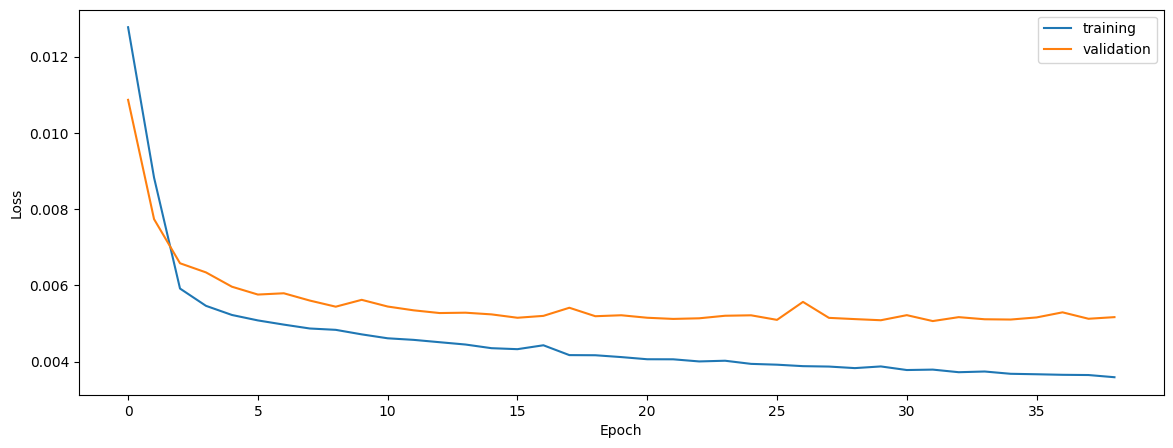

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7991051984963309
0.7306589472879254
0.7550867830354022


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.7991051984963309
0.7306589472879254
0.7550867830354022


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8007140957439103
0.7392753051464532
0.7583651870390999


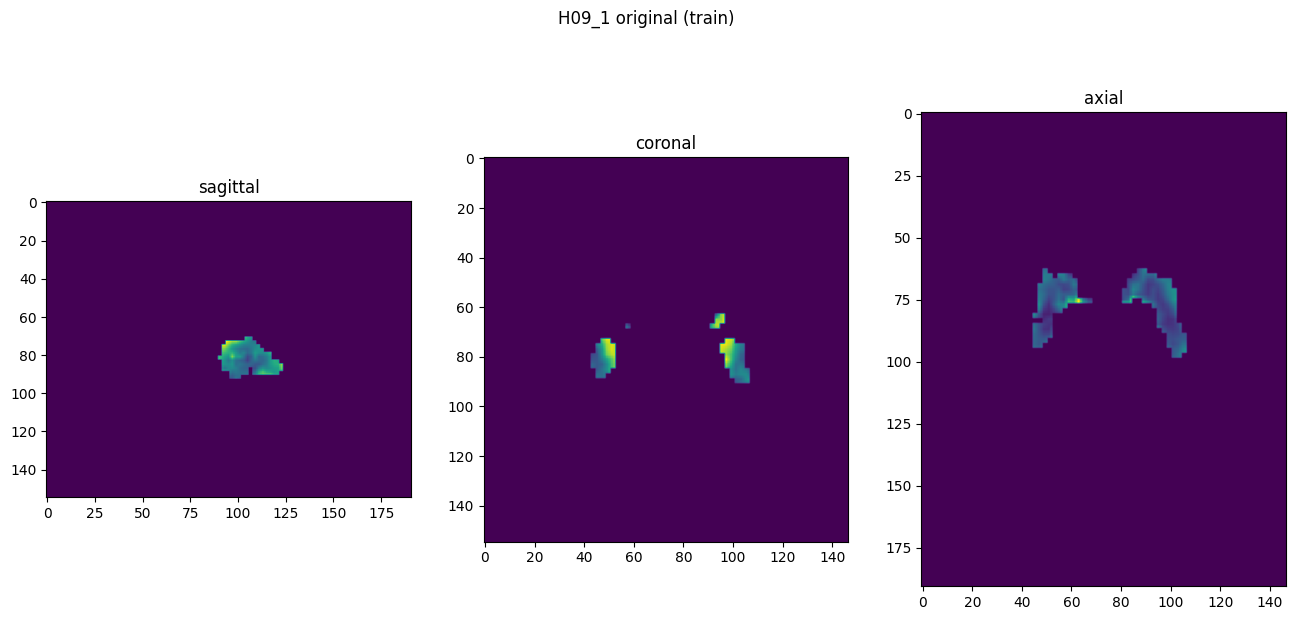

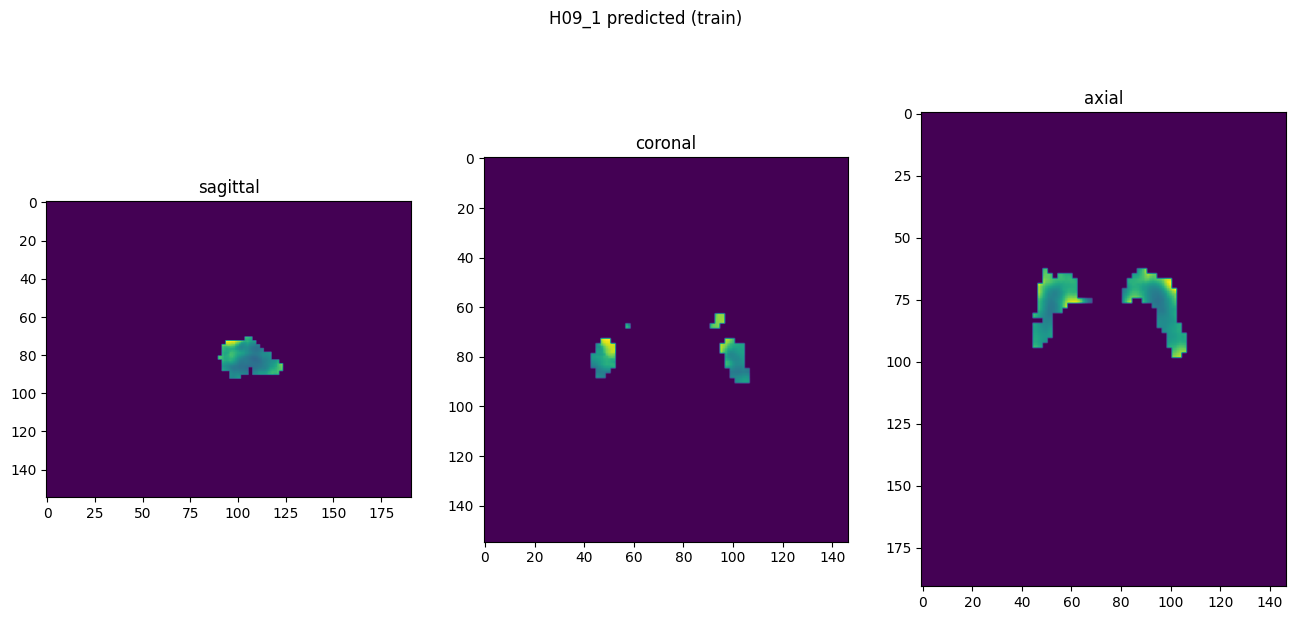

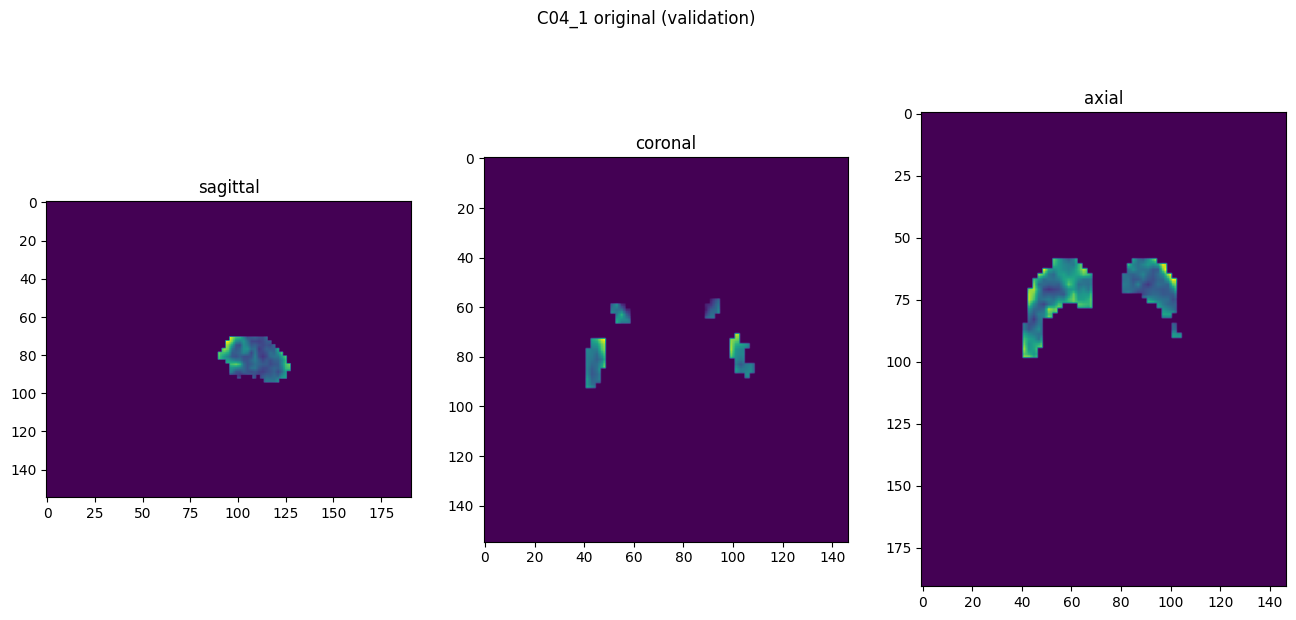

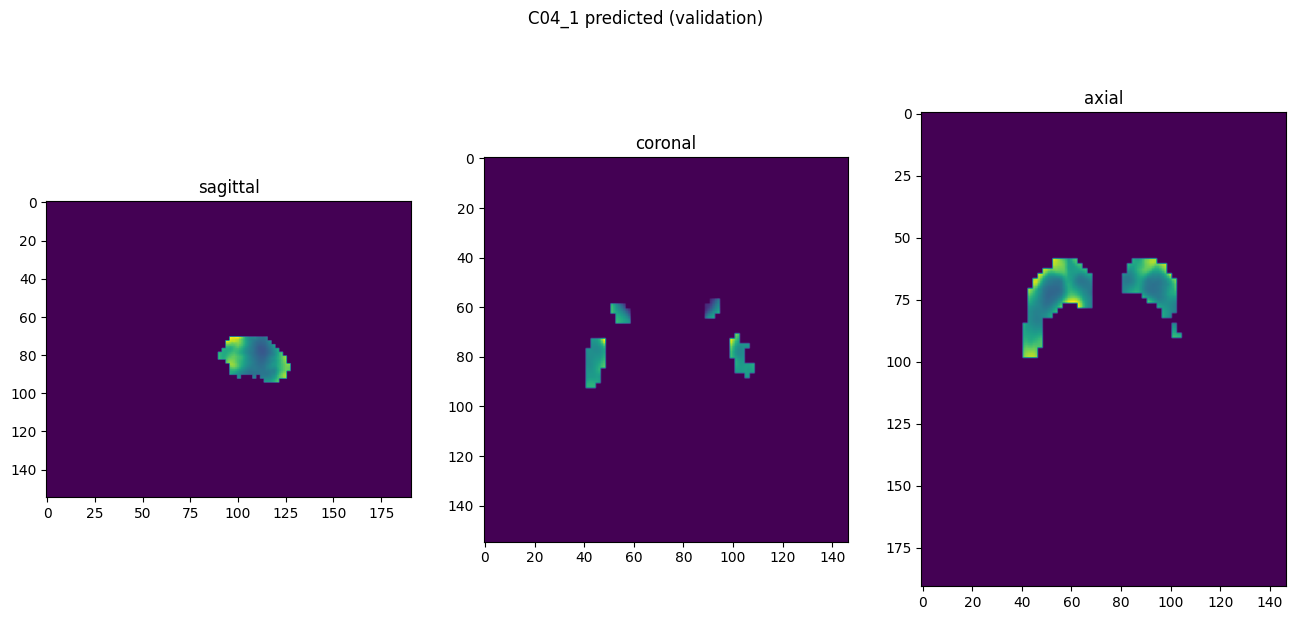

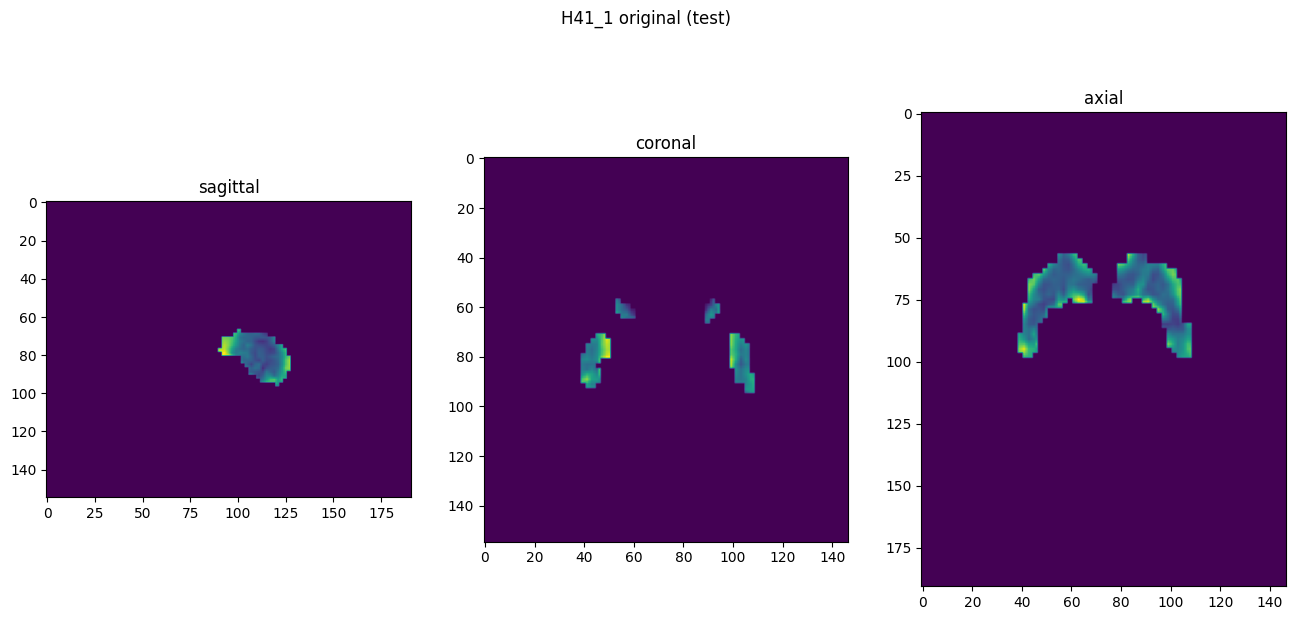

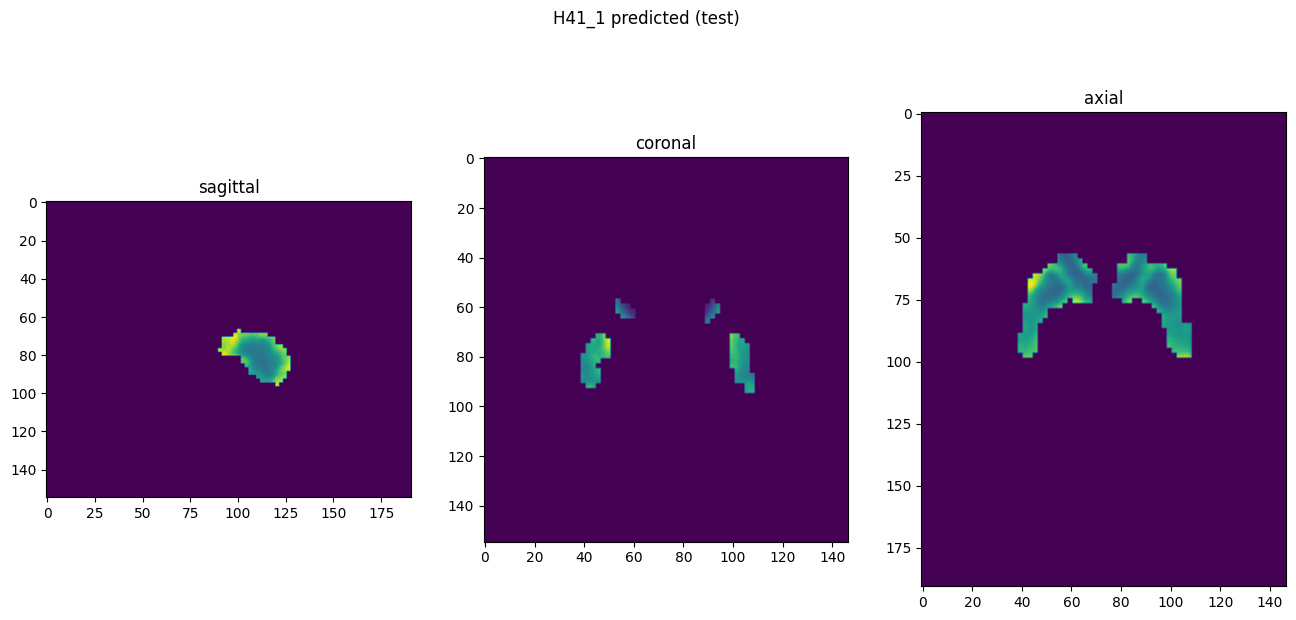

In [10]:
showResults(model, gen, threshold=None, background=False)